In [2]:
import sys
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from importlib import reload
import analysis2 as a2
reload(a2)
from IPython.display import display, HTML

from flutype.utils import django_setup
from flutype.models import Spot, RawSpotCollection
import preprocessing as pre
import spot2intensity as sp
import seaborn as sns
from itertools import combinations
from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison
import matplotlib.cm as cm
import skimage.io


****************************************
RUNNING IN DEVELOP
****************************************


In [3]:
reload(pre)
reload(a2)

<module 'analysis2' from '/home/janekg89/Develop/Pycharm_Projects/flutype_analysis_web/analysis2.py'>

In [5]:
studies = ["microarray_2018_03_21"]
#viruses = ['A/Aichi/2/68(H3N2)-X31-2018-04-13','A/California/7/2009(H1N1)-2018-04-13','A/Hong Kong/4801/2014(H3N2)-2018-04-13','A/Brisbane/10/2007(H3N2)-2018-04-13','A/Brisbaine/59/2007(H1N1)-2018-04-13']
#viruses = ['A/California/7/2009(H1N1)-2018-03-20','A/Panama/2007/1999(H3N2)-2017']
#viruses = ['A/Panama/2007/1999(H3N2)-2017']
from django.db.models import Q

spots_dj = Spot.objects.filter(raw_spot__raw_spot_collection__studies__sid__in=studies)

cs = ["2018_03_21_slide_33"]

#spots_dj =  spots_dj.filter(raw_spot__raw_spot_collection__sid__in=cs)
spots_before = spots_dj.filter(spot_collection__sid = "before")
spots_quant = spots_dj.filter(spot_collection__sid = "quant1")



#spots_dj = spots_quant.filter(raw_spot__lig_mob_batch__sid__in = viruses)
spots_dj = spots_quant.filter(Q(circle_quality__gte = 0.1) | Q(raw_spot__lig_fix_batch__sid = None) )

data = a2.Data(spots_dj=spots_dj)#.outlier_filtering()


In [6]:
#col_30 = a2.Spots(df=data.spots_pd, a_im =im)

In [15]:
data.spots_pd.head()

Ligand Batch  Ligand Batch Concentration Ligand  \
0        Empty                         NaN    NaN   
1         P105                         1.0   P105   
2         P104                         1.0   P104   
3       LF-0.1                         0.1     LF   
4         P103                         1.0   P103   

                          Analyte Batch  Analyte Batch Concentraion  \
0  A/Victoria/361/2011(H3N2)-2018-04-13                    0.972519   
1  A/Victoria/361/2011(H3N2)-2018-04-13                    0.972519   
2  A/Victoria/361/2011(H3N2)-2018-04-13                    0.972519   
3  A/Victoria/361/2011(H3N2)-2018-04-13                    0.972519   
4  A/Victoria/361/2011(H3N2)-2018-04-13                    0.972519   

                     Analyte    Intensity           Std  Circle Quality  \
0  A/Victoria/361/2011(H3N2)   135.258675     70.705699        0.187500   
1  A/Victoria/361/2011(H3N2)   148.380952    190.429089        0.458333   
2  A/Victoria/361/2011(H3N2)   164.079286    140.787512        0.586538   
3  A/Victoria/361/2011(H3N2)    66.627760     43.830116        0.765625   
4  A/Victoria/361/2011(H3N2)  7660.276644  16426.183270        0.402778   

   Circle Radius    ...     Square Y Left  Square X Right  Square Y Right  \
0           10.0    ...            3441.5          1067.5          3500.5   
1           12.0    ...            2073.5           592.5          2132.5   
2           18.0    ...            2073.5           525.5          2132.5   
3           10.0    ...            2074.5           458.5          2133.5   
4           12.0    ...            2074.5           390.5          2133.5   

            Collection                  Study  Row Column Collection Type  \
0  2018_03_21_slide_38  microarray_2018_03_21   57     15          quant1   
1  2018_03_21_slide_39  microarray_2018_03_21   34      8          quant1   
2  2018_03_21_slide_39  microarray_2018_03_21   34      7          quant1   
3  2018_03_21_slide_39  microarray_2018_03_21   34      6          quant1   
4  2018_03_21_slide_39  microarray_2018_03_21   34      5          quant1   

   Replica       rsd  
0        0  0.522744  
1        0  1.283380  
2        0  0.858046  
3        0  0.657836  
4        0  2.144333  

[5 rows x 23 columns]

In [18]:
data.spots_pd["Rsd"] = data.spots_pd["Std"]/data.spots_pd["Intensity"]
spots_filter1 = data.spots_pd[(data.spots_pd["Rsd"] < 1.5)]
frames ={}
for n, d in spots_filter1.groupby(["Collection", "Ligand Batch"]):
    low_bound = d["Intensity"].median()*0.7
    x = d[d["Intensity"] > low_bound]
    frames[n] = x
spots_new = pd.concat(frames)

In [20]:
data = a2.Data(spots_pd=spots_new)

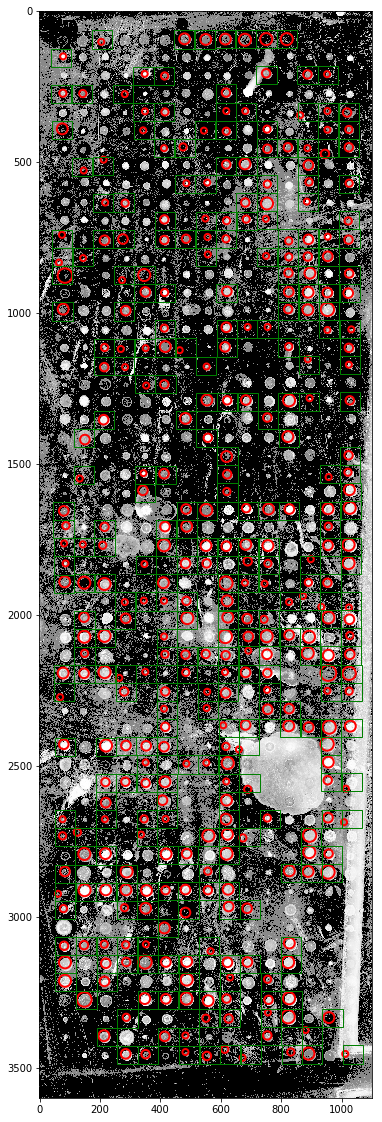

In [68]:
col = ["2018_03_21_slide_50"]
rsp = RawSpotCollection.objects.get(sid__in =col) 
im = skimage.io.imread(rsp.processstep_set.last().image)
col_spo = a2.Spots(df=data.subset_collection(col).spots_pd, a_im =im)
col_spo.plot_grid(figsize=(40,20))

In [8]:
def spot_quality_collection(this_data):
    all_collections = this_data.spots_pd.Collection.dropna().unique()
    frames=[]
    for i in np.linspace(0.001,0.8,30):
        for c in all_collections:
            spots_dj = Spot.objects.filter(spot_collection__sid = "quant1")
            spots_dj = spots_dj.filter(raw_spot__raw_spot_collection__sid__in=[c])
            max_spots = len(spots_dj)
            spots_dj = spots_dj.filter(circle_quality__gte = i)
            frames.append(pd.Series(data=[c,i,len(spots_dj)], index=["Collection","Circle Quality","Number"]))
    d_circ = pd.concat(frames,axis=1).T
    d_circ.Number = d_circ.Number.astype(int)/ max_spots
    spot_amount = pd.pivot_table(d_circ,values=["Number"],columns=["Collection"],index=["Circle Quality"])
    return  spot_amount[list(spot_amount.iloc[15].sort_values(ascending=False).index)]

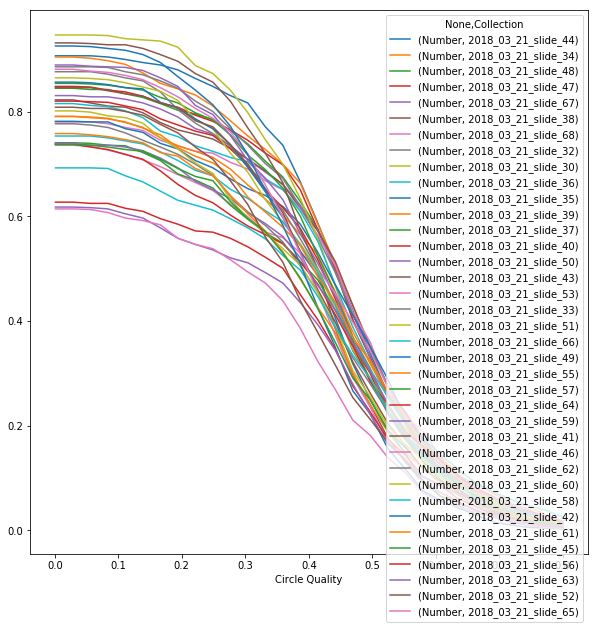

In [51]:
spot_quality_collection(data).plot(figsize=(10,10))

In [22]:
frames = {}
for peptide, d_pep in data.spots_pd.groupby(["Ligand Batch","Analyte Batch"]):
    
    x_mean=  d_pep["Intensity"].mean()
    df =  d_pep.copy()
    df["Intensity_norm"] = ( d_pep["Intensity"]- d_pep["Intensity"].mean())/ d_pep["Intensity"].mean()
    frames[peptide]=df
spots_new = pd.concat(frames)

In [23]:
spots_new

Ligand Batch  \
Empty A/Aichi/2/68(H3N2)-X31-2018-04-13           2018_03_21_slide_58 Empty 20032        Empty   
                                                                            20036        Empty   
                                                                            20157        Empty   
                                                                            20180        Empty   
                                                                            20181        Empty   
                                                                            20183        Empty   
                                                                            20369        Empty   
                                                                            20370        Empty   
                                                                            20409        Empty   
                                                                            20448        Empty   
                                                                            21259        Empty   
                                                                            21272        Empty   
                                                                            21280        Empty   
                                                                            21438        Empty   
                                                                            21453        Empty   
                                                                            21455        Empty   
                                                                            21463        Empty   
                                                                            21468        Empty   
                                                                            21470        Empty   
                                                  2018_03_21_slide_63 Empty 19977        Empty   
                                                                            19979        Empty   
                                                                            19985        Empty   
                                                                            20790        Empty   
                                                                            20793        Empty   
                                                                            20845        Empty   
                                                                            20896        Empty   
                                                                            20901        Empty   
                                                                            20903        Empty   
                                                                            20960        Empty   
                                                                            20973        Empty   
...                                                                                        ...   
P136  A/Hong Kong/4801/2014(H3N2)-2018-04-13      2018_03_21_slide_62 P136  19558         P136   
                                                  2018_03_21_slide_66 P136  18098         P136   
                                                                            18599         P136   
                                                                            19591         P136   
                                                                            19863         P136   
      A/Panama/2007/1999(H3N2)-2018-04-13         2018_03_21_slide_50 P136  14318         P136   
                                                  2018_03_21_slide_51 P136  15526         P136   
                                                                            15896         P136   
                                                  2018_03_21_slide_52 P136  14190         P136   
                                                                

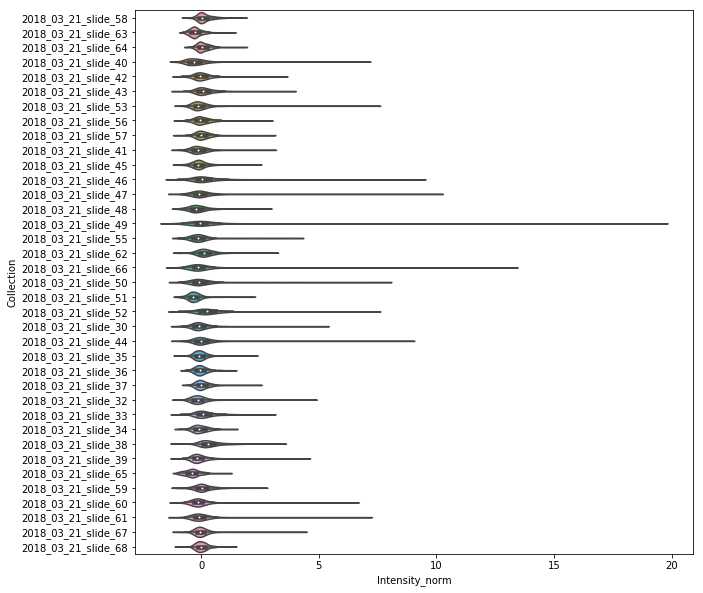

In [24]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
sns.violinplot(data=spots_new, y="Collection", x="Intensity_norm",ax=ax)

In [25]:
mean_collection = pre.mean_on_collection(data.spots_pd)


In [26]:
mean_on_ana = pre.mean_on_analyte_batch(data.spots_pd)


In [27]:
ma = mean_on_ana.groupby(["Analyte Batch"]).mean()["Intensity_rsd"]
ma

Analyte Batch
A/Aichi/2/68(H3N2)-X31-2018-04-13              0.327186
A/Beijing/32/1992(H3N2)-2018-04-13             0.490241
A/Brisbaine/59/2007(H1N1)-2018-04-13           0.360685
A/Brisbane/10/2007(H3N2)-2018-04-13            0.468938
A/California/7/2009(H1N1)-2018-04-13           0.518500
A/Hong Kong/4801/2014(H3N2)-2018-04-13         0.472602
A/Panama/2007/1999(H3N2)-2018-04-13            0.574541
A/Perth/16/2009(H3N2)-2018-04-13               0.400713
A/Switzerland/9715293/2013(H3N2)-2018-04-13    0.335444
A/Texas/50/2012(H3N2)-2018-04-13               0.424652
A/Victoria/361/2011(H3N2)-2018-04-13           0.524285
Mi45-2018-04-13                                0.486725
VicAlla-2018-04-13                             0.327350
Name: Intensity_rsd, dtype: float64

In [28]:
mc = mean_collection.groupby(["Analyte Batch"]).mean()["Intensity_rsd"]
mc


Analyte Batch
A/Aichi/2/68(H3N2)-X31-2018-04-13              0.211218
A/Beijing/32/1992(H3N2)-2018-04-13             0.327450
A/Brisbaine/59/2007(H1N1)-2018-04-13           0.247850
A/Brisbane/10/2007(H3N2)-2018-04-13            0.281752
A/California/7/2009(H1N1)-2018-04-13           0.329977
A/Hong Kong/4801/2014(H3N2)-2018-04-13         0.267850
A/Panama/2007/1999(H3N2)-2018-04-13            0.320913
A/Perth/16/2009(H3N2)-2018-04-13               0.293145
A/Switzerland/9715293/2013(H3N2)-2018-04-13    0.247588
A/Texas/50/2012(H3N2)-2018-04-13               0.286572
A/Victoria/361/2011(H3N2)-2018-04-13           0.268252
Mi45-2018-04-13                                0.316328
VicAlla-2018-04-13                             0.253399
Name: Intensity_rsd, dtype: float64

In [29]:
mean_ligand_col = mean_collection.groupby(["Ligand Batch"]).mean()#.sort_values(by="Intensity")
mean_ligand_ana = mean_on_ana.groupby(["Ligand","Ligand Batch"]).mean()#.sort_values(by="Intensity")


In [30]:
mean_ligand_ana

Ligand Batch Concentration  Analyte Batch Concentraion  \
Ligand Ligand Batch                                                           
LF     LF-0.0001                         0.0001                    2.943424   
       LF-0.001                          1.0000                    2.809587   
       LF-0.01                           0.0100                    2.809587   
       LF-0.05                           0.0500                    2.809587   
       LF-0.1                            0.1000                    2.809587   
       LF-0.5                            0.5000                    2.809587   
Nenad  Nenad                             1.0000                    2.943424   
P007   P007                              1.0000                    2.809587   
P008   P008                              1.0000                    2.809587   
P009   P009                              1.0000                    2.809587   
P010   P010                              1.0000                    2.809587   
P012   P012                              1.0000                    2.809587   
P013   P013                              1.0000                    2.809587   
P043   P043                              1.0000                    3.106747   
P044   P044                              1.0000                    3.115314   
P045.3 P045.3                            1.0000                    2.809587   
P047   P047                              1.0000                    2.809587   
P048   P048                              1.0000                    2.809587   
P050   P050                              1.0000                    2.809587   
P052   P052                              1.0000                    2.809587   
P054   P054                              1.0000                    2.922886   
P055   P055                              1.0000                    2.809587   
P056   P056                              1.0000                    2.962676   
P057   P057                              1.0000                    2.809587   
P059   P059                              1.0000                    2.809587   
P060   P060                              1.0000                    2.809587   
P061   P061                              1.0000                    2.809587   
P063   P063                              1.0000                    2.809587   
P065   P065                              1.0000                    2.809587   
P066   P066                              1.0000                    2.809587   
...                                         ...                         ...   
P099   P099                              1.0000                    2.809587   
P100   P100                              1.0000                    2.809587   
P101   P101                              1.0000                    2.809587   
P102   P102                              1.0000                    2.943424   
P103   P103                              1.0000                    2.943424   
P104   P104                              1.0000                    2.809587   
P105   P105                              1.0000                    2.809587   
P106   P106                              1.0000                    2.809587   
P114   P114                              1.0000                    2.809587   
P115   P115                              1.0000                    2.809587   
P116   P116                              1.0000                    2.809587   
P117   P117                              1.0000                    2.809587   
P118   P118                              1.0000                    2.809587   
P119   P119                              1.0000                    2.809587   
P120   P120                              1.0000                    2.943424   
P121   P121                              1.0000                    2.809587   
P122   P122                              1.0000                    2.962676   
P123   P123                              1.0000                    2.80

In [56]:
import numpy as np
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot,iplot
print (__version__) # requires version >= 1.9.0

#Always run this the command before at the start of notebook
init_notebook_mode(connected=True)
import plotly.graph_objs as go

trace1 = go.Scatter(
    x=mean_ligand_col["Intensity"],
    y=mean_ligand_ana["Intensity_rsd"],
    #z=test_data[:,2],
    text = mean_ligand_col.index,
    mode='markers+text',
    hoverinfo='text',
    textposition='bottom',
    #hoverlabel=dict(bgcolor=list(colors)),
    marker=dict(
        size=7,
        #color=colors,                # set color to an array/list of desired values
        colorscale='Jet',   # choose a colorscale
        opacity=0.99)
)
trace2 = go.Scatter(
    x=mean_ligand_ana["Intensity"],
    y=mean_ligand_ana["Intensity_rsd"]-mean_ligand_col["Intensity_rsd"],
    #z=test_data[:,2],
    text = mean_ligand_col.index,
    mode ='markers+text',
    hoverinfo='text',

    textposition='bottom',
    #hoverlabel=dict(bgcolor=list(colors)),
    marker=dict(
        size=7,
        #color="r",                # set color to an array/list of desired values
        colorscale='Jet',   # choose a colorscale
        opacity=0.99)
)

this = [trace1]
layout = go.Layout(
    #scene=dict(
    #    xaxis = dict(showspikes=False),
    #    yaxis = dict(showspikes=False),
    #    zaxis = dict(showspikes=False),

        

     #   )
    )
fig = go.Figure(data=this, layout=layout)
iplot(fig, filename='3d-scatter-colorscale')
#plt.scatter(mean_ligand["Intensity"],mean_ligand["Intensity_rsd"])
#plt.show()

2.6.0


In [54]:
mc

Analyte Batch
A/Aichi/2/68(H3N2)-X31-2018-04-13              0.211218
A/Beijing/32/1992(H3N2)-2018-04-13             0.327450
A/Brisbaine/59/2007(H1N1)-2018-04-13           0.247850
A/Brisbane/10/2007(H3N2)-2018-04-13            0.281752
A/California/7/2009(H1N1)-2018-04-13           0.329977
A/Hong Kong/4801/2014(H3N2)-2018-04-13         0.267850
A/Panama/2007/1999(H3N2)-2018-04-13            0.320913
A/Perth/16/2009(H3N2)-2018-04-13               0.293145
A/Switzerland/9715293/2013(H3N2)-2018-04-13    0.247588
A/Texas/50/2012(H3N2)-2018-04-13               0.286572
A/Victoria/361/2011(H3N2)-2018-04-13           0.268252
Mi45-2018-04-13                                0.316328
VicAlla-2018-04-13                             0.253399
Name: Intensity_rsd, dtype: float64

In [33]:
ma

Analyte Batch
A/Aichi/2/68(H3N2)-X31-2018-04-13              0.327186
A/Beijing/32/1992(H3N2)-2018-04-13             0.490241
A/Brisbaine/59/2007(H1N1)-2018-04-13           0.360685
A/Brisbane/10/2007(H3N2)-2018-04-13            0.468938
A/California/7/2009(H1N1)-2018-04-13           0.518500
A/Hong Kong/4801/2014(H3N2)-2018-04-13         0.472602
A/Panama/2007/1999(H3N2)-2018-04-13            0.574541
A/Perth/16/2009(H3N2)-2018-04-13               0.400713
A/Switzerland/9715293/2013(H3N2)-2018-04-13    0.335444
A/Texas/50/2012(H3N2)-2018-04-13               0.424652
A/Victoria/361/2011(H3N2)-2018-04-13           0.524285
Mi45-2018-04-13                                0.486725
VicAlla-2018-04-13                             0.327350
Name: Intensity_rsd, dtype: float64

In [34]:
#plt.scatter(mc["Intensity"],mc["Intensity_rsd"])
#plt.show()

In [35]:
1-mc/ma

Analyte Batch
A/Aichi/2/68(H3N2)-X31-2018-04-13              0.354440
A/Beijing/32/1992(H3N2)-2018-04-13             0.332063
A/Brisbaine/59/2007(H1N1)-2018-04-13           0.312834
A/Brisbane/10/2007(H3N2)-2018-04-13            0.399170
A/California/7/2009(H1N1)-2018-04-13           0.363592
A/Hong Kong/4801/2014(H3N2)-2018-04-13         0.433244
A/Panama/2007/1999(H3N2)-2018-04-13            0.441444
A/Perth/16/2009(H3N2)-2018-04-13               0.268442
A/Switzerland/9715293/2013(H3N2)-2018-04-13    0.261911
A/Texas/50/2012(H3N2)-2018-04-13               0.325161
A/Victoria/361/2011(H3N2)-2018-04-13           0.488347
Mi45-2018-04-13                                0.350090
VicAlla-2018-04-13                             0.225908
Name: Intensity_rsd, dtype: float64

In [36]:
#df_new = data.subset_ligand_batches(["LF-0.0001","LF-0.001","LF-0.01","LF-0.05","LF-0.1","LF-0.5","Empty", "Nenad"])


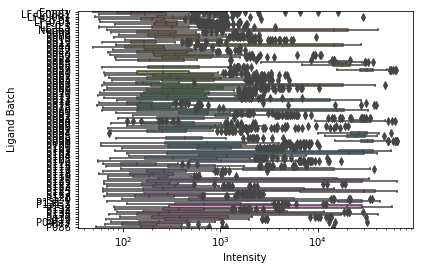

In [37]:
sns.boxplot(data=data.spots_pd, x="Intensity", y="Ligand Batch")
plt.xscale("log")

/home/janekg89/Develop/Pycharm_Projects/flutype_analysis_web/preprocessing.py:14: RuntimeWarning:

invalid value encountered in double_scalars



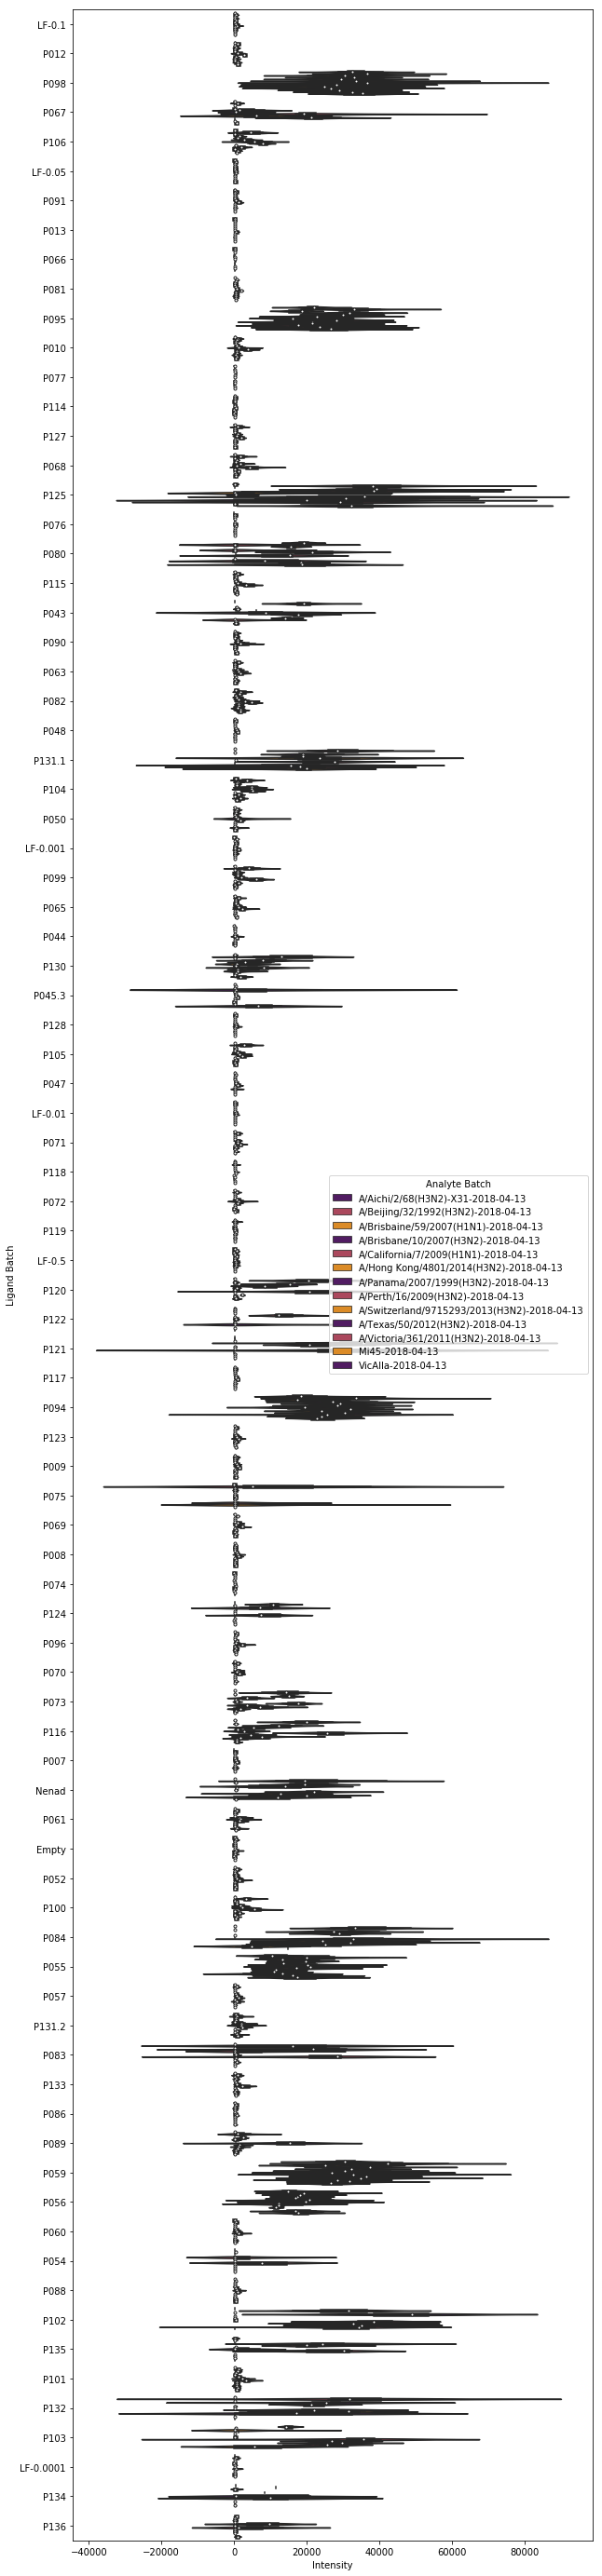

In [38]:
d = data.outlier_filtering()
#d = d.subset_ligand_batches(["P076"])
fig ,ax = plt.subplots(figsize=(10,50))

ax = sns.violinplot(hue="Analyte Batch",
                    x="Intensity",
                    bw=.9, 
                    y="Ligand Batch",
                    scale="width", 
                    data=d.spots_pd.sort_values(by="Analyte Batch"),
                    #split=True,
                    color="white",
                    palette=sns.color_palette("inferno",n_colors=3),


                    )
'''
ax = sns.swarmplot(hue="Analyte Batch",
                   y="Ligand Batch", 
                   x="Intensity",
                   palette=sns.color_palette("inferno",n_colors=3),
                   #color="white",
                   data=d.spots_pd.sort_values(by="Analyte Batch"),
                   size=8,
                   #split=True,
                   edgecolor="grey",
                   linewidth=0.1,)
'''

        
#ax.legend_.remove()
plt.show()

In [39]:
frames = {}

for name, d in data.spots_pd.groupby("Collection"):
    mask = d["Ligand Batch"] == "LF-1"
    d_LF = d[mask]["Intensity"].mean()
    mask = d["Ligand Batch"] == "Empty"
    d_Empty = d[mask]["Intensity"].mean()
    x = d.copy()
    x["Intensity"] = (d["Intensity"]/d_Empty)#/(d_LF+ d_Empty)
    frames[name] = x
spots_pd_norm = pd.concat(frames)



In [40]:
data_norm=a2.Data(spots_pd=spots_pd_norm)

In [43]:

peptide_c_signif = data.ligand_batch_significance()



In [44]:
peptide_c_signif

Ligand Batch  Ligand Ligand Batch Concentration  \
0          LF-0.5      LF                        0.5   
1            P068    P068                          1   
2            P117    P117                          1   
3            P071    P071                          1   
4            P013    P013                          1   
5            P088    P088                          1   
6            P082    P082                          1   
7            P059    P059                          1   
8            P128    P128                          1   
9            P044    P044                          1   
11           P070    P070                          1   
12           P080    P080                          1   
13           P096    P096                          1   
14           P119    P119                          1   
15           P010    P010                          1   
16         LF-0.1      LF                        0.1   
17           P104    P104                          1   
19           P127    P127                          1   
20           P052    P052                          1   
21           P103    P103                          1   
22           P009    P009                          1   
23           P061    P061                          1   
24           P133    P133                          1   
25           P063    P063                          1   
26           P086    P086                          1   
27           P114    P114                          1   
28          Nenad   Nenad                          1   
29           P074    P074                          1   
31           P130    P130                          1   
32           P132    P132                          1   
...           ...     ...                        ...   
6352         P043    P043                          1   
6353         P081    P081                          1   
6355         P105    P105                          1   
6356         P125    P125                          1   
6359         P094    P094                          1   
6360         P075    P075                          1   
6361         P101    P101                          1   
6362      LF-0.01      LF                       0.01   
6363         P060    P060                          1   
6364     LF-0.001      LF                          1   
6365         P056    P056                          1   
6366         P047    P047                          1   
6367         P069    P069                          1   
6368         P123    P123                          1   
6369       P131.2  P131.2                          1   
6370         P012    P012                          1   
6371         P065    P065                          1   
6373         P073    P073                          1   
6374         P083    P083                          1   
6375       P045.3  P045.3                          1   
6376         P095    P095                          1   
6377         P115    P115                          1   
6378         P118    P118                          1   
6379         P091    P091                          1   
6380         P076    P076                          1   
6381         P099    P099                          1   
6382         P090    P090                          1   
6383         P124    P124                          1   
6384         P077    P077                          1   
6385         P072    P072                          1   

                                        Analyte Batches  Significance  \
0     (A/Aichi/2/68(H3N2)-X31-2018-04-13, A/Beijing/...   1.88121e-27   
1     (A/Aichi/2/68(H3N2)-X31-2018-04-13, A/Beijing/...   3.21154e-26   
2     (A/Aichi/2/68(H3N2)-X31-2018-04-13, A/Beijing/...   6.58361e-09   
3     (A/Aichi/2/68(H3N2)-X31-2018-04-13, A/Beijing/...   3.68875e-26   
4     (A/Aichi/2/68(H3N2)-X31-2018-04-13, A/Beijing/...   8.53373e-11   
5     (A/Aichi/2/68(H3N2)-X31-2018-04-13, A/Beijing/...   4.77479e-24   
6     (A/Aichi/2/68(H

/home/janekg89/Envs/flutype_web_analysis/lib/python3.5/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



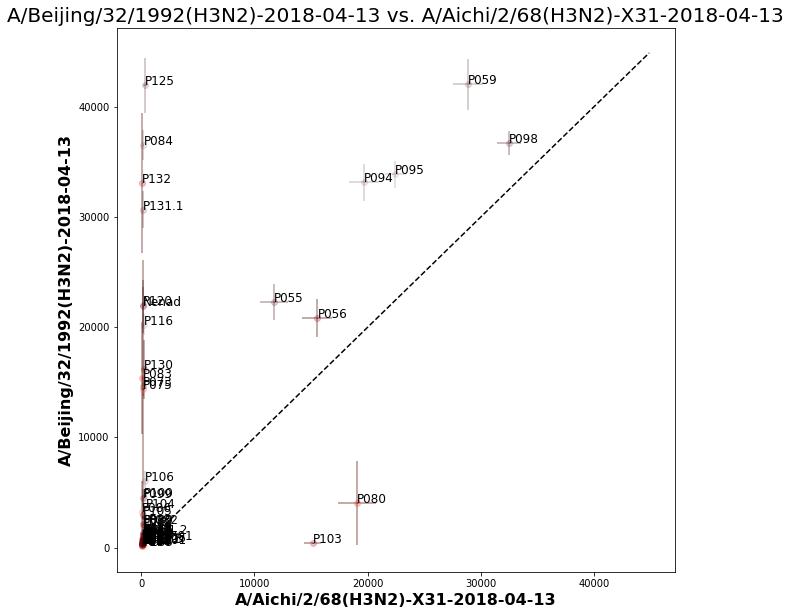

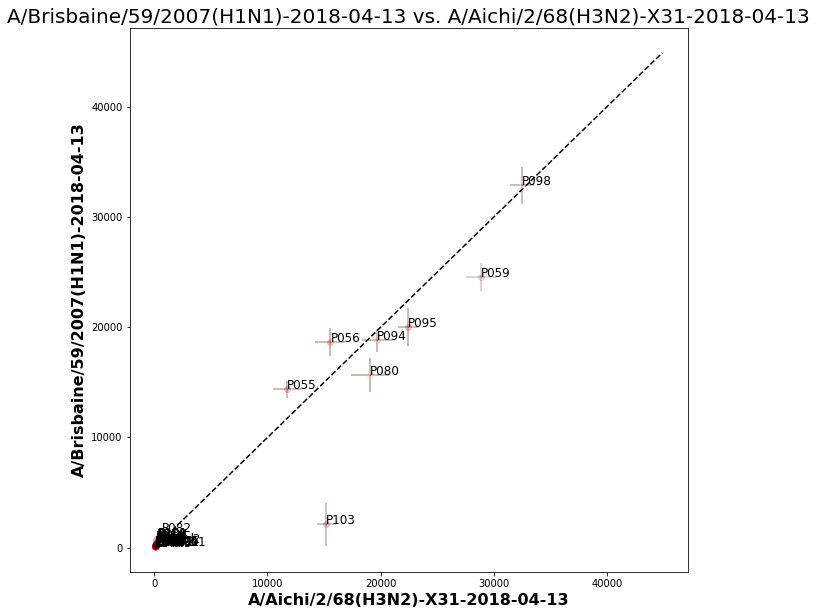

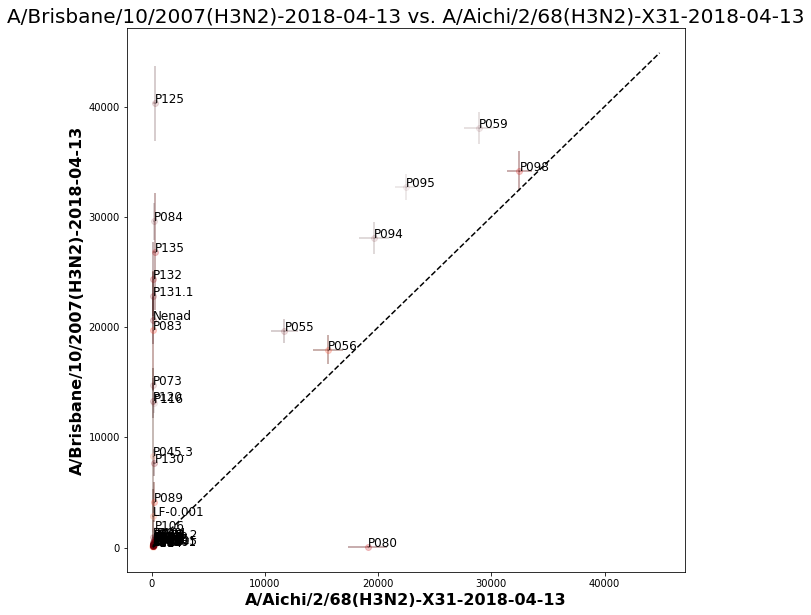

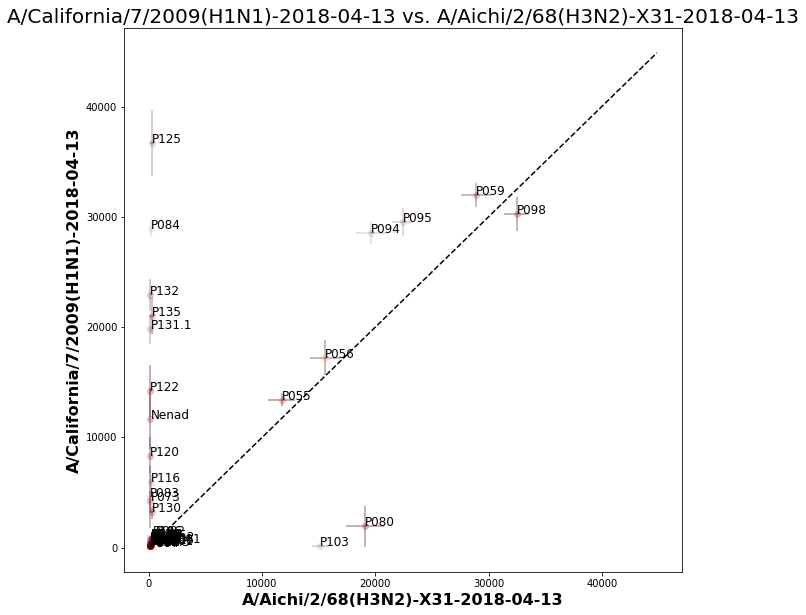

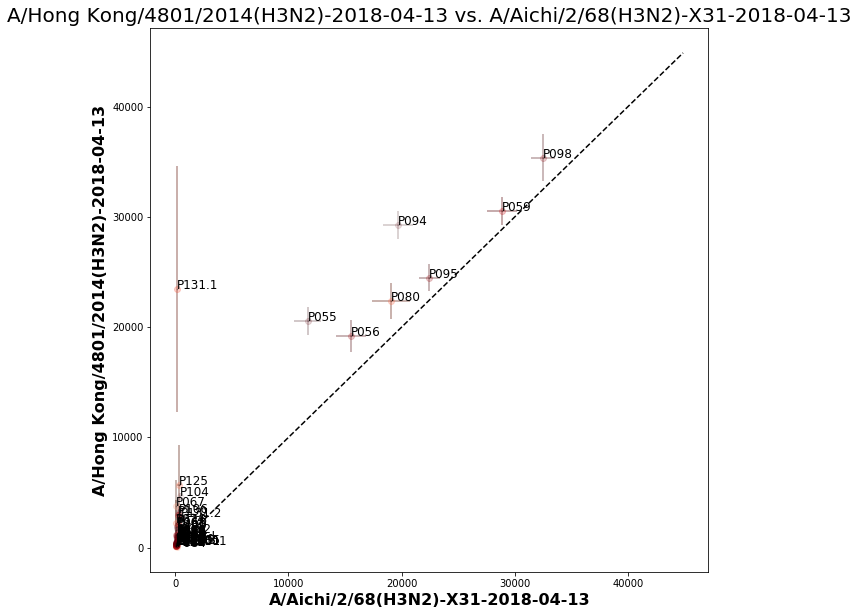

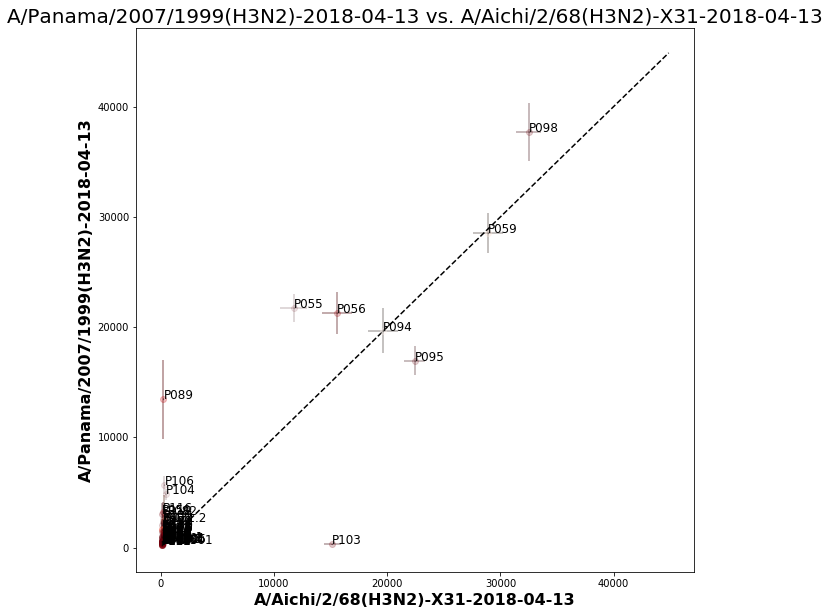

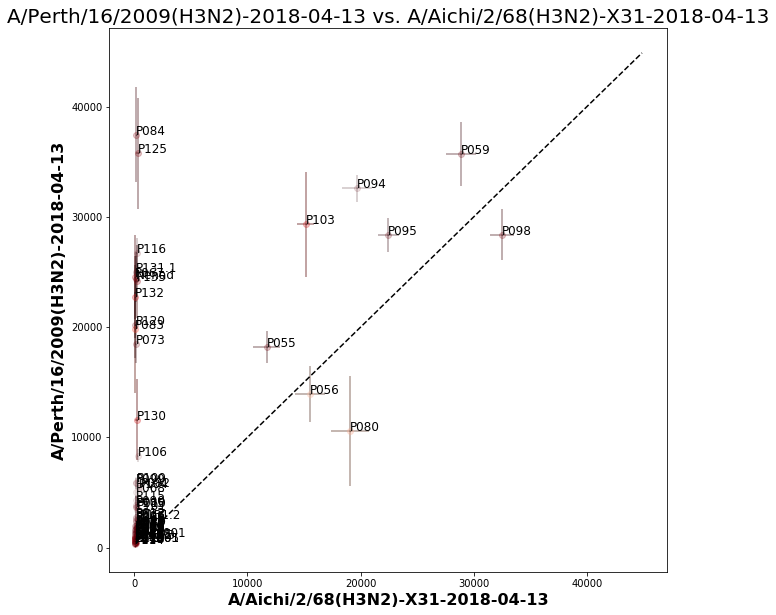

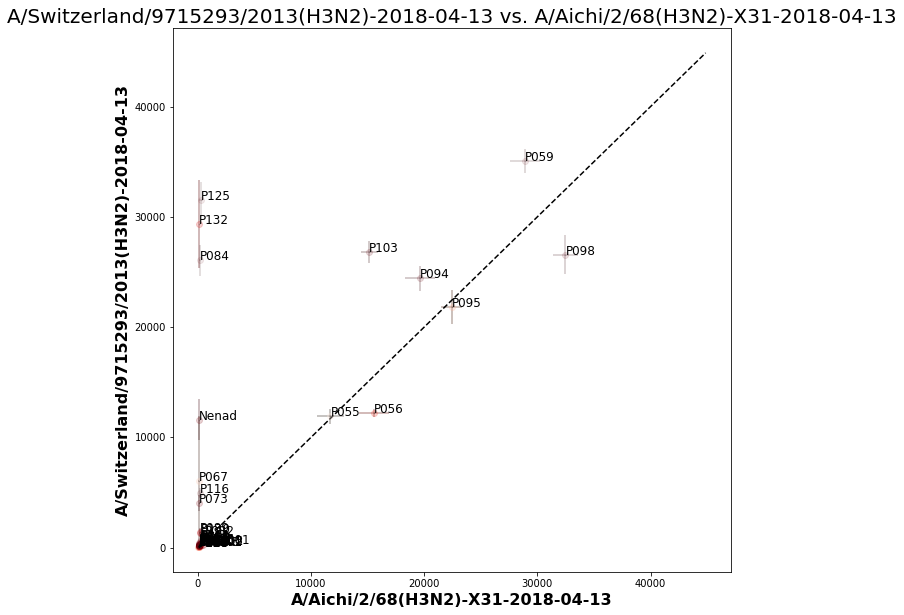

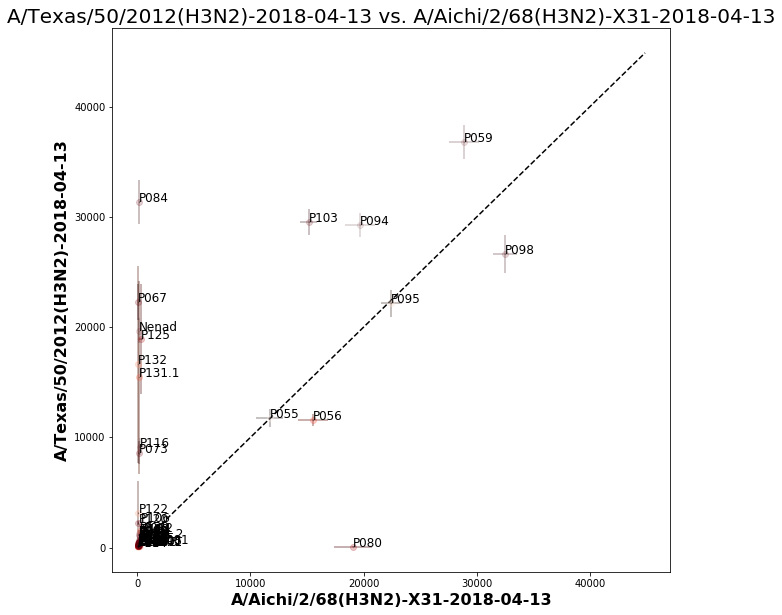

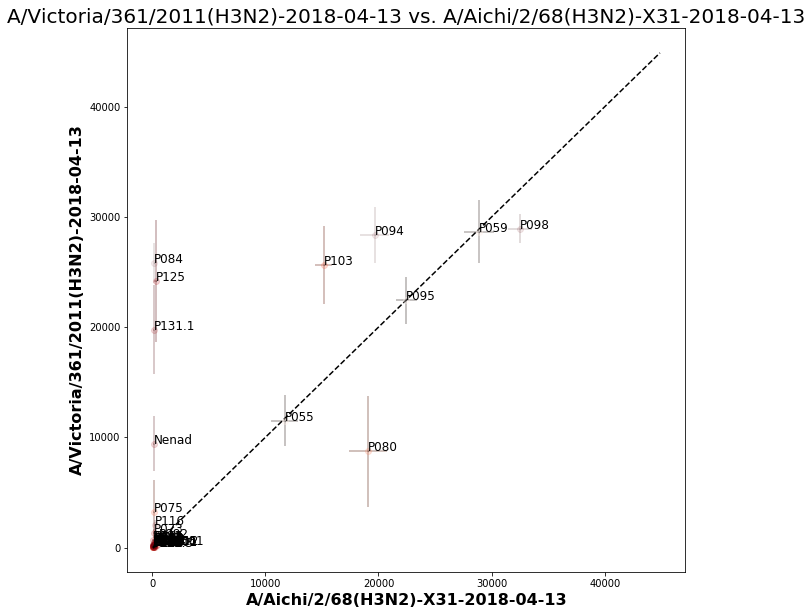

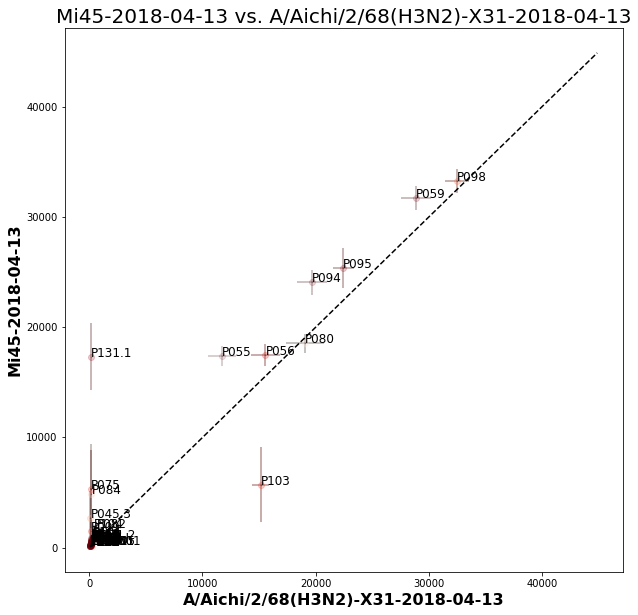

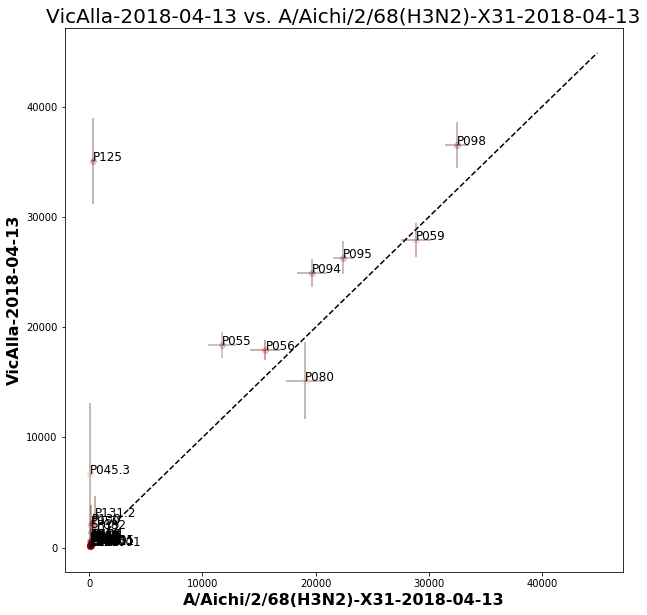

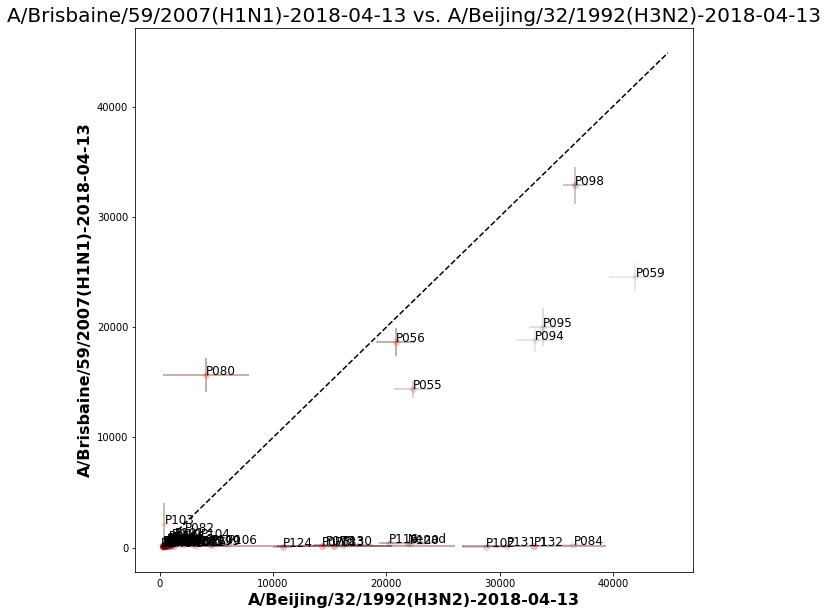

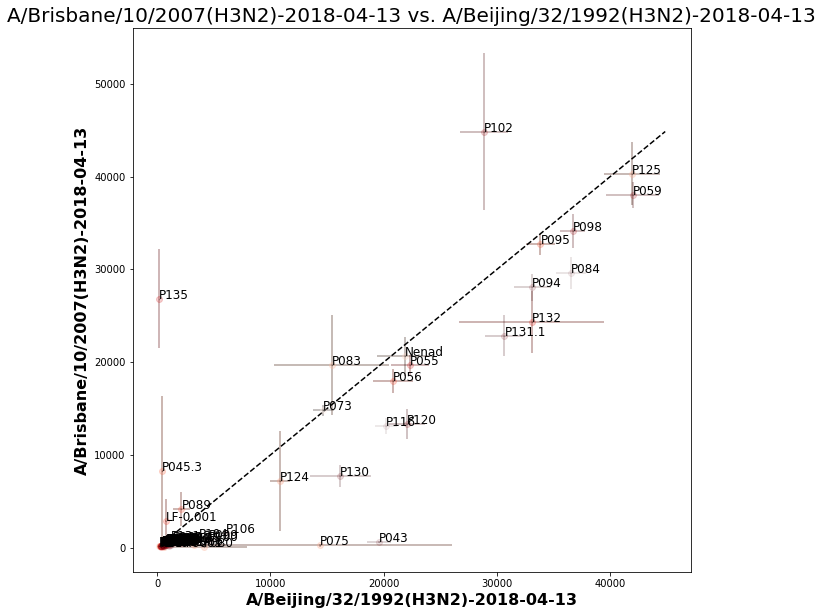

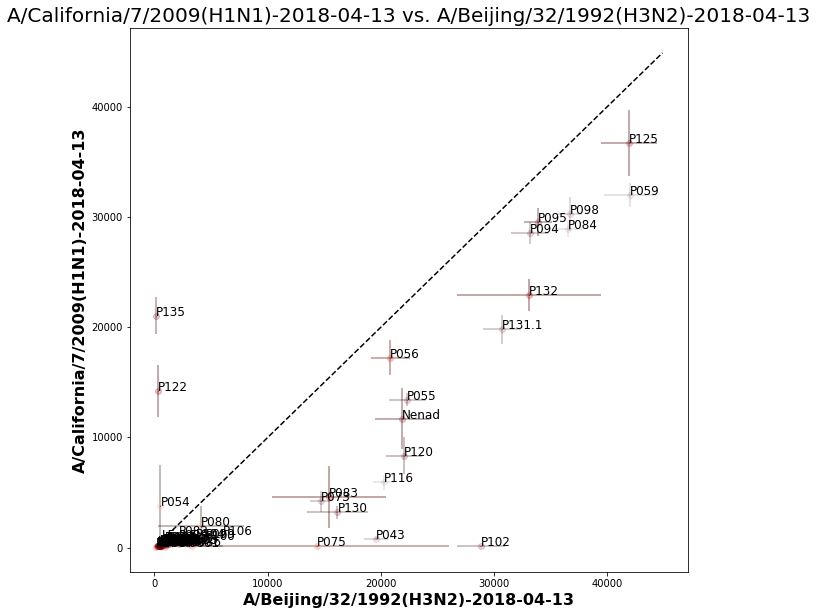

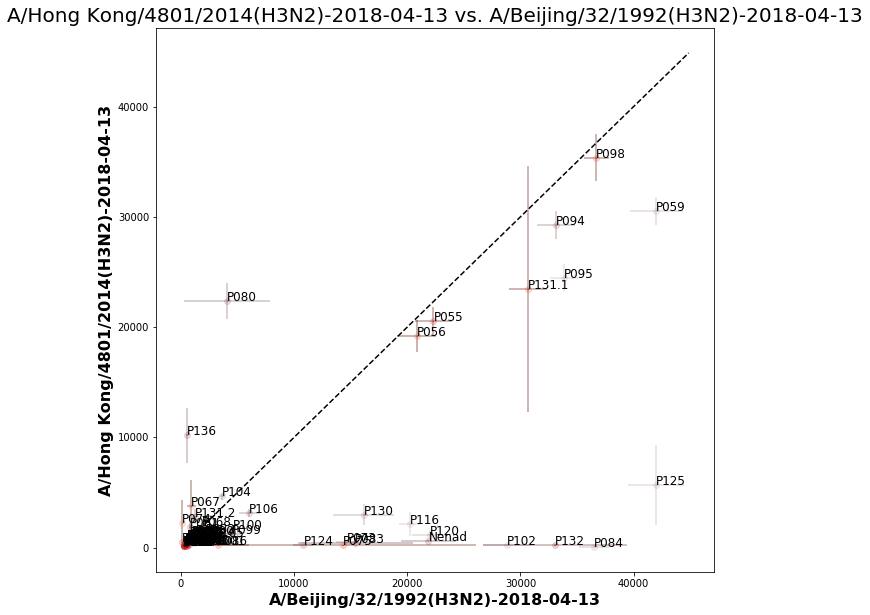

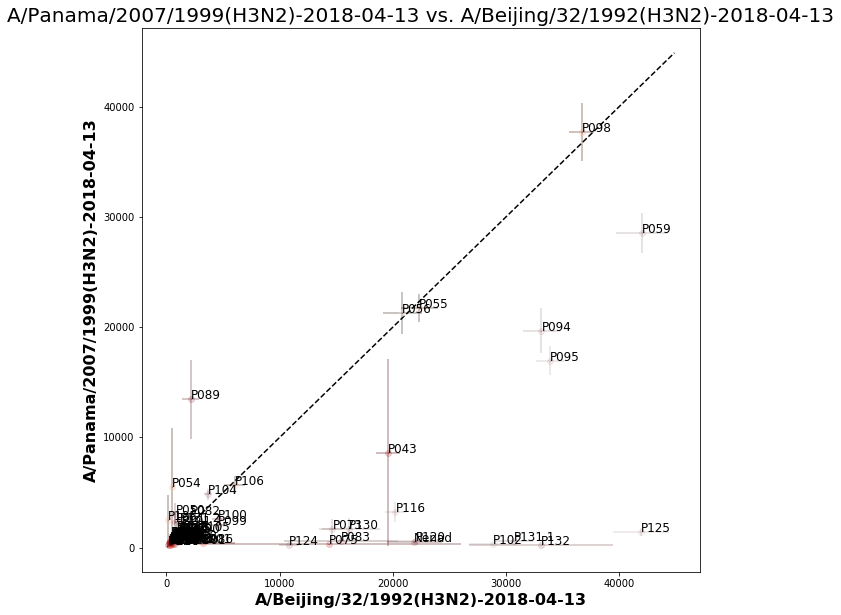

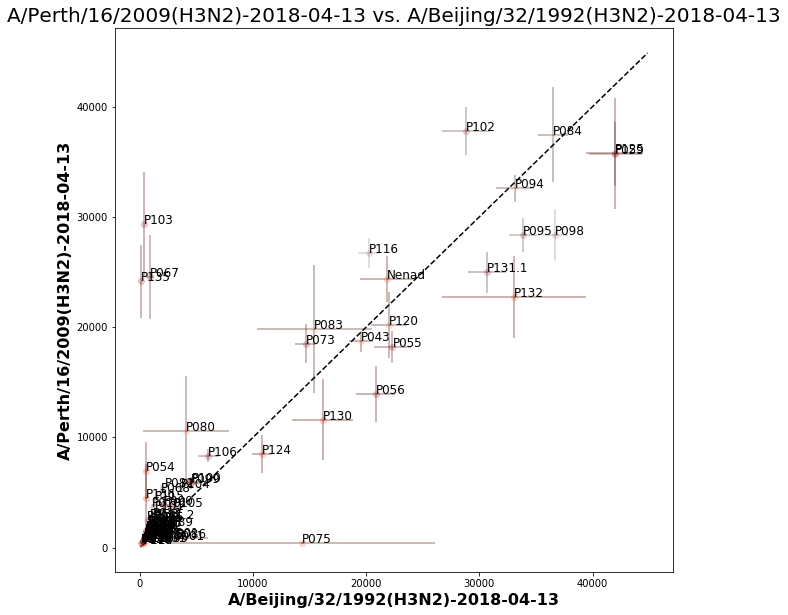

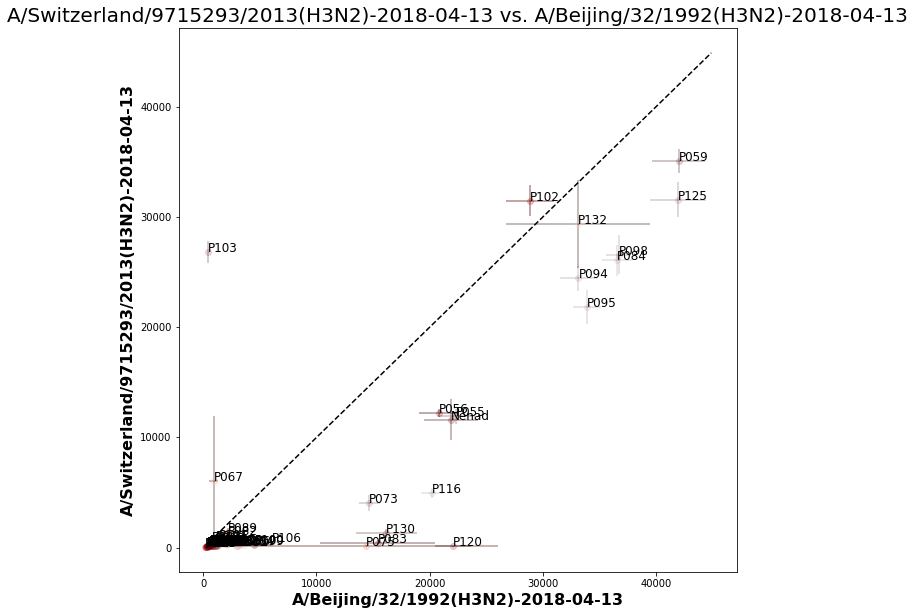

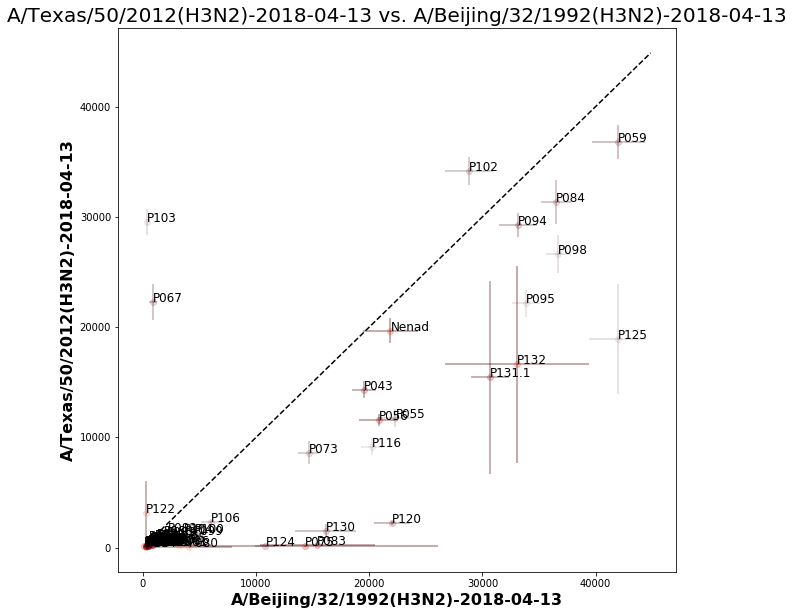

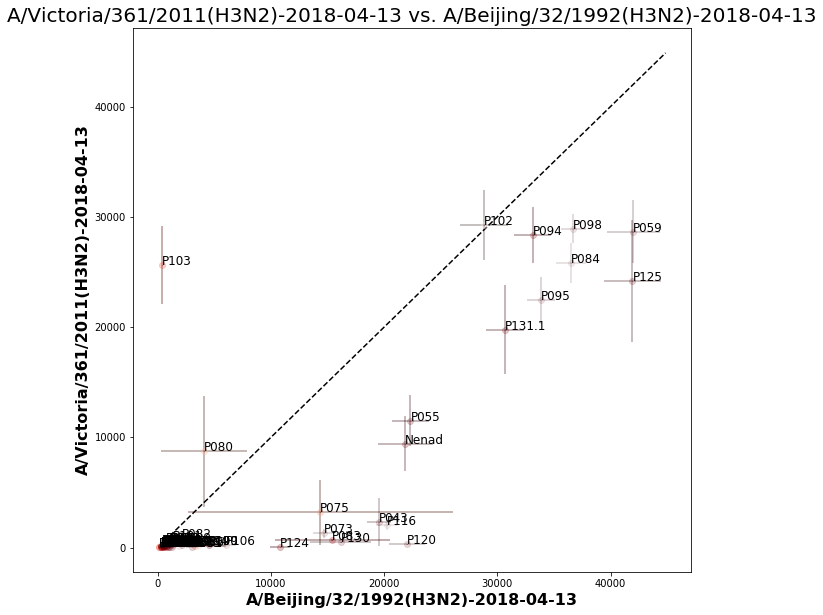

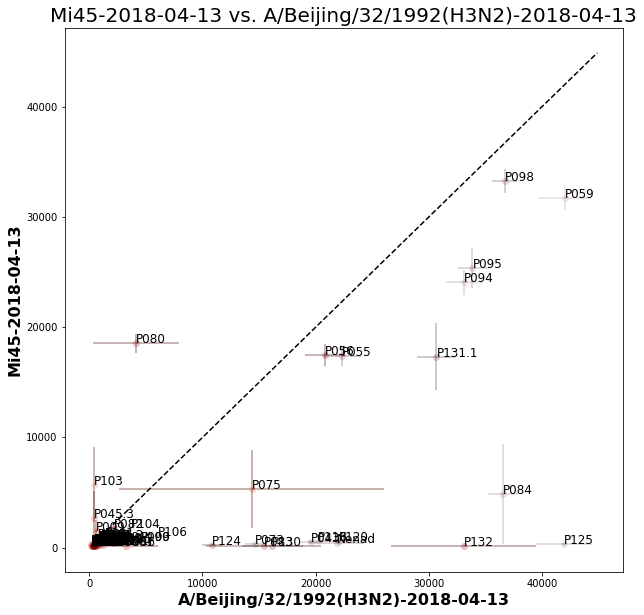

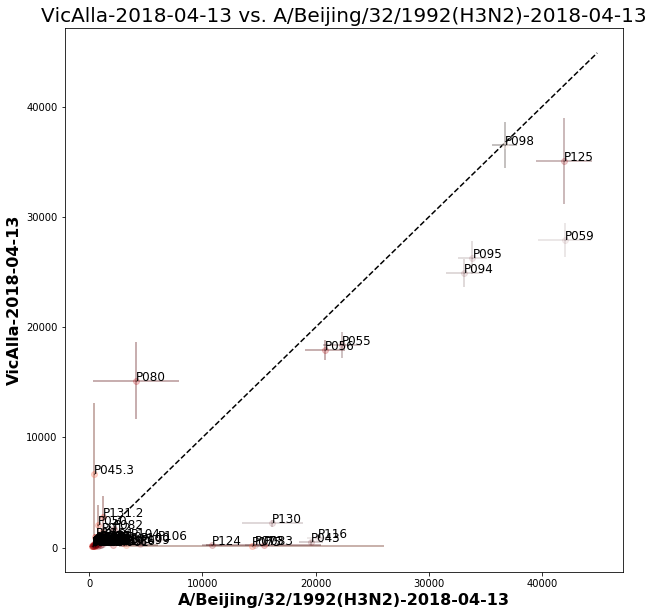

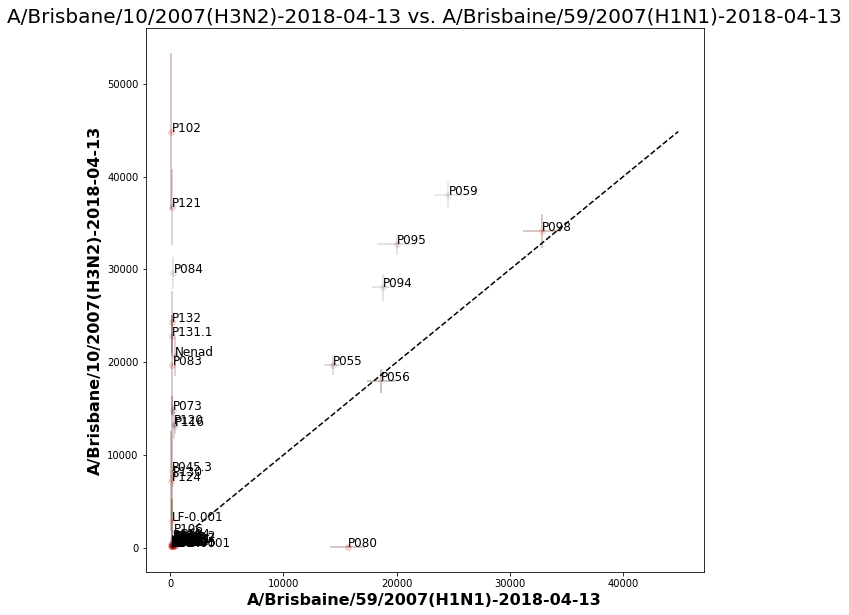

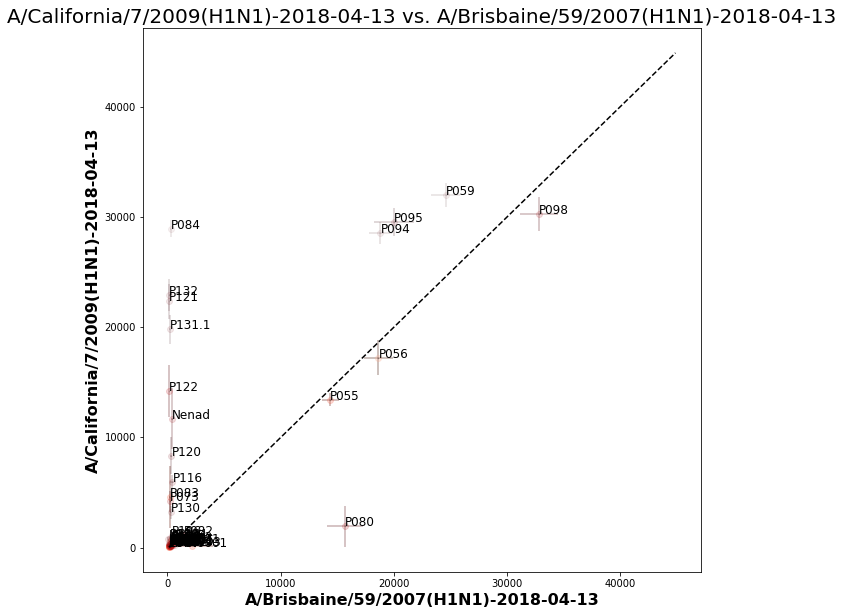

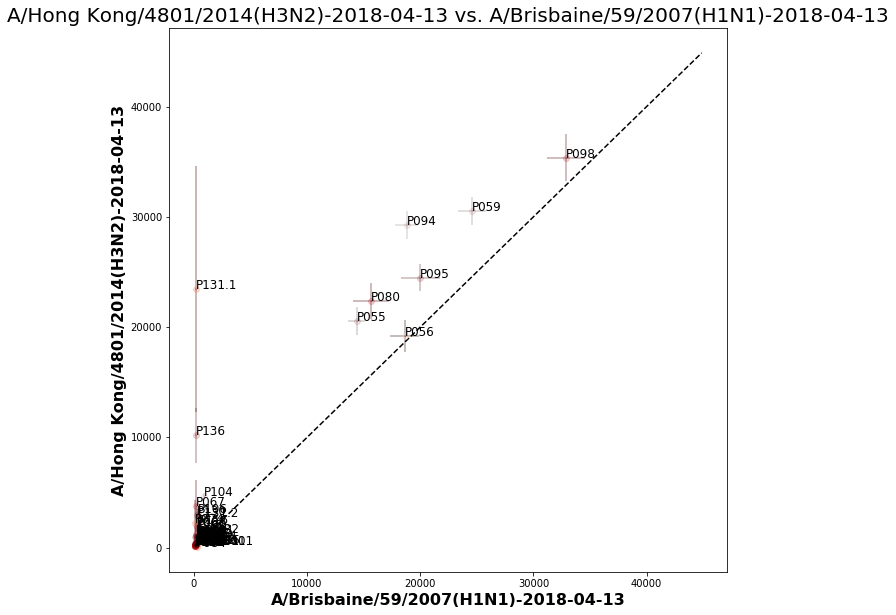

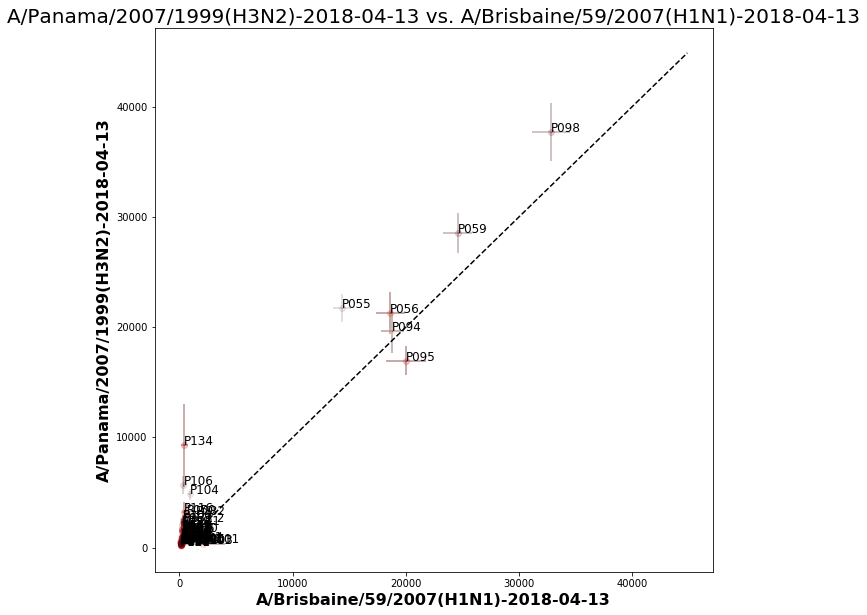

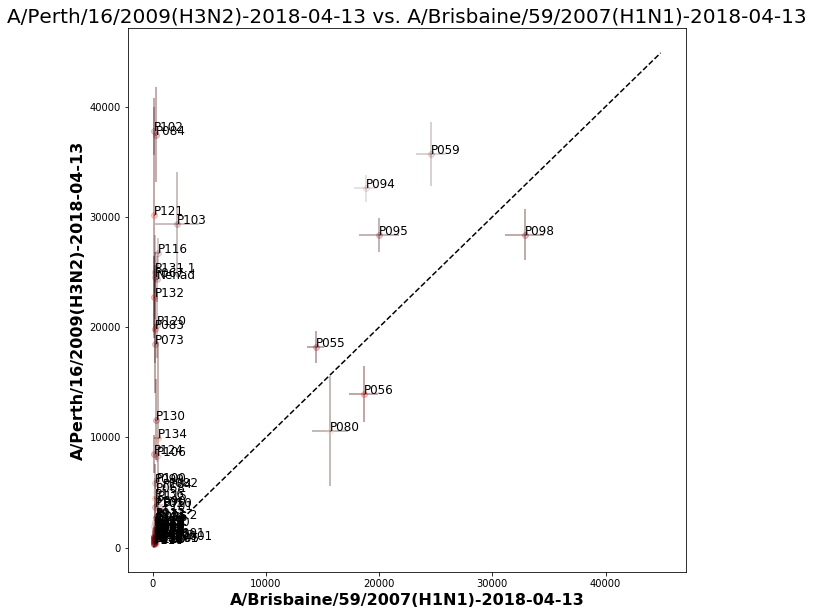

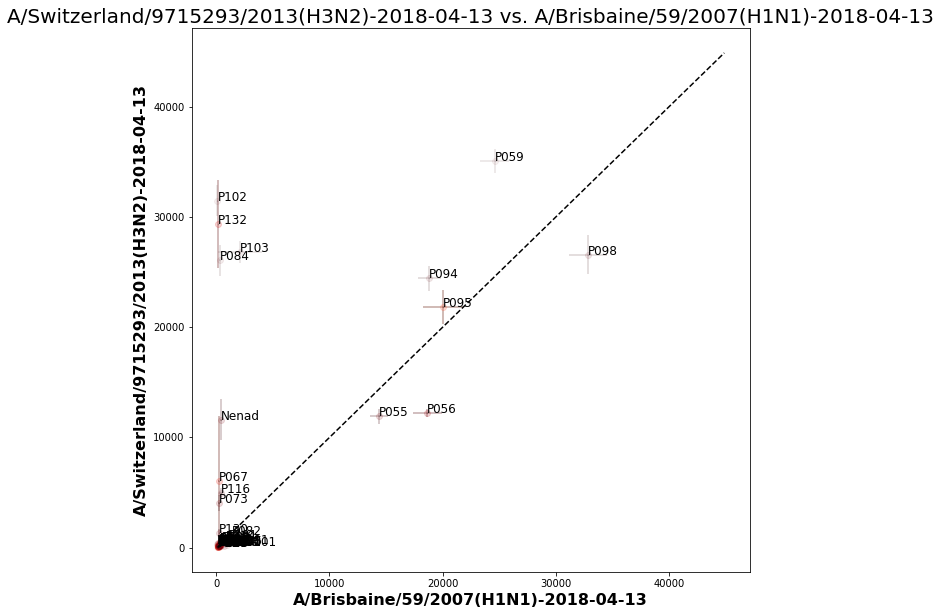

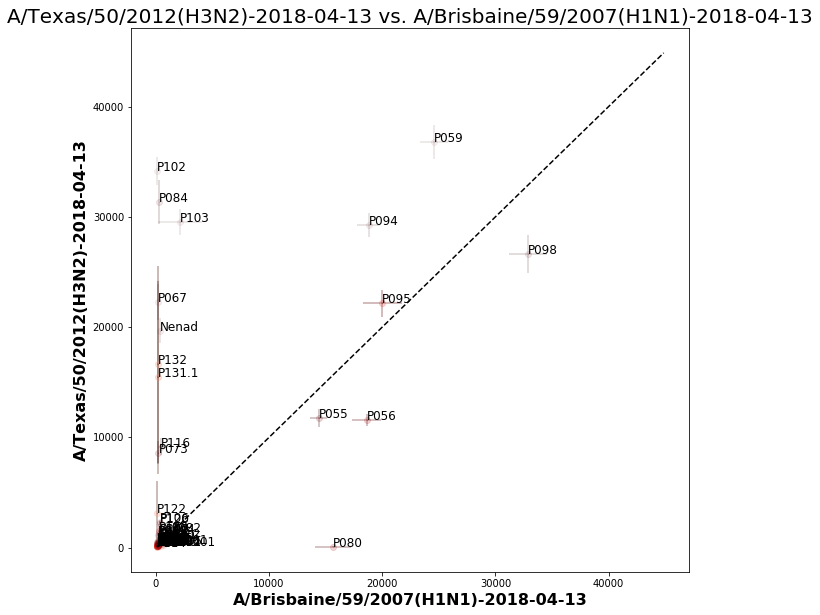

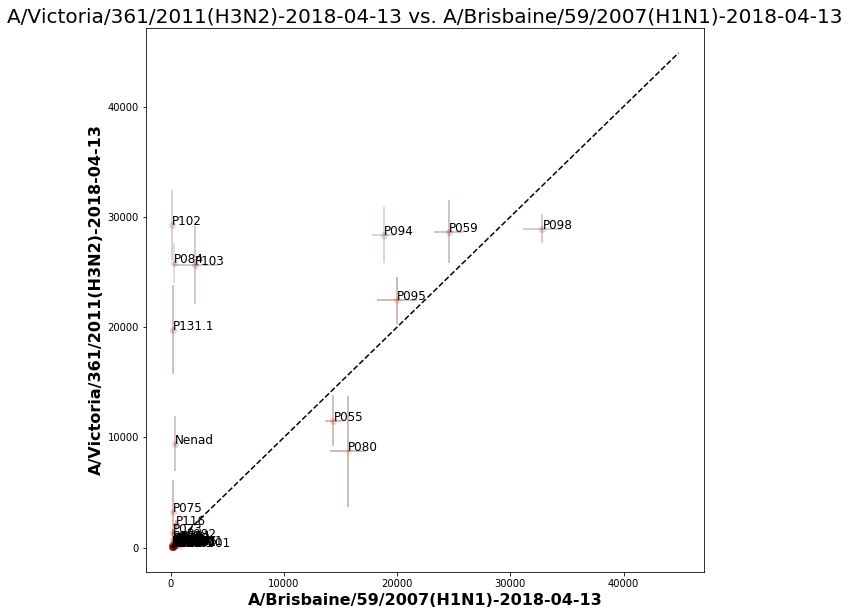

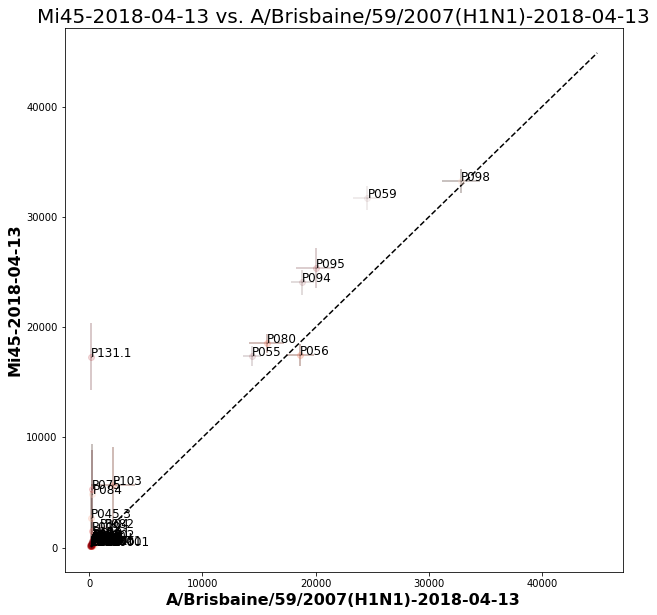

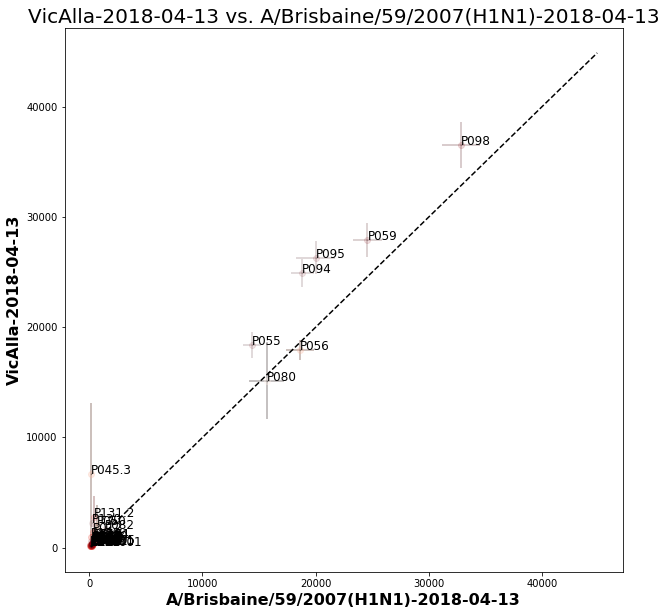

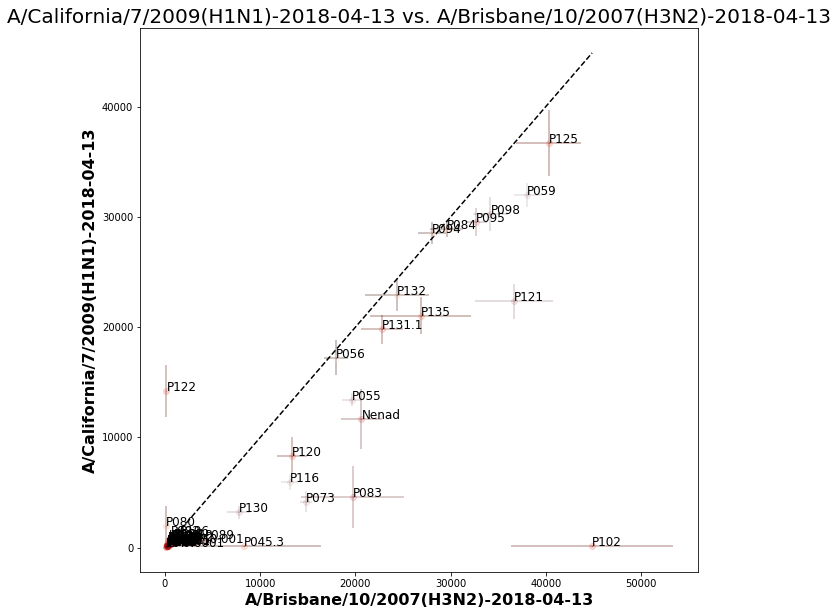

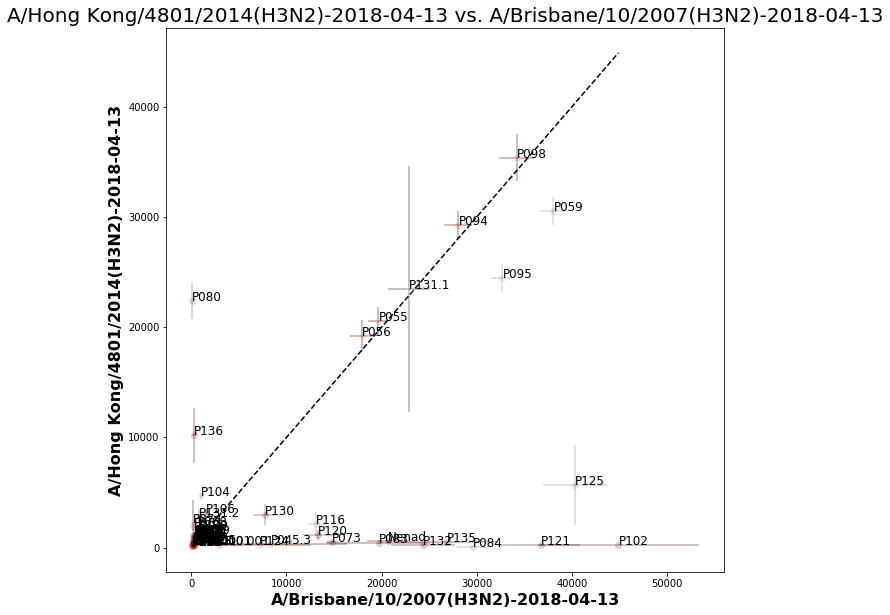

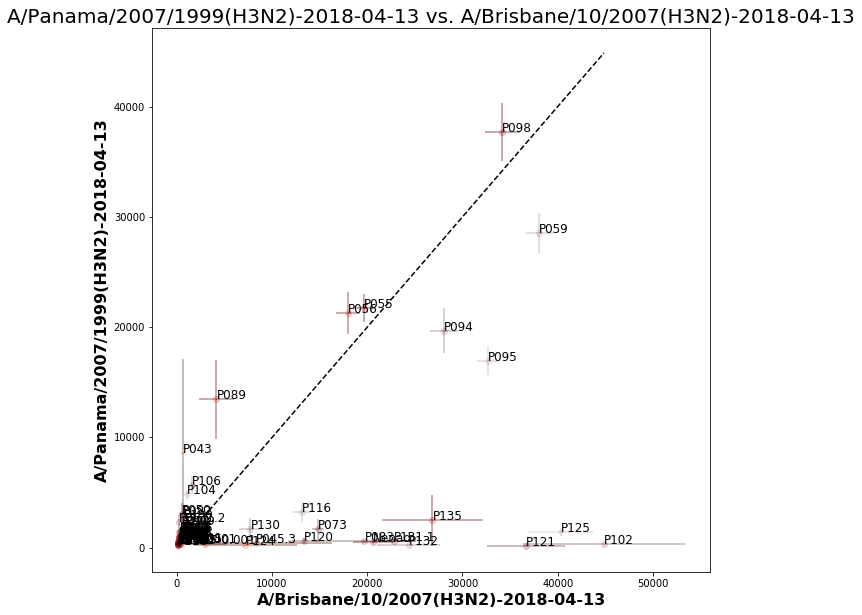

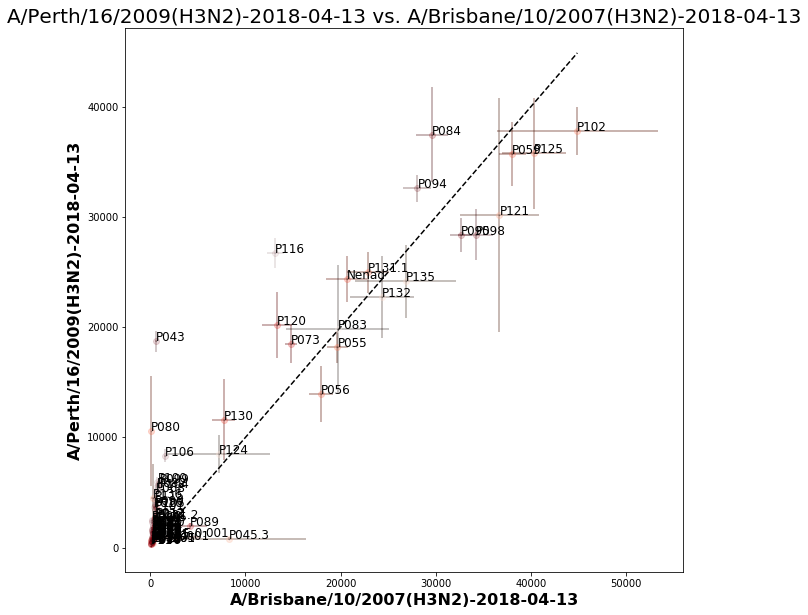

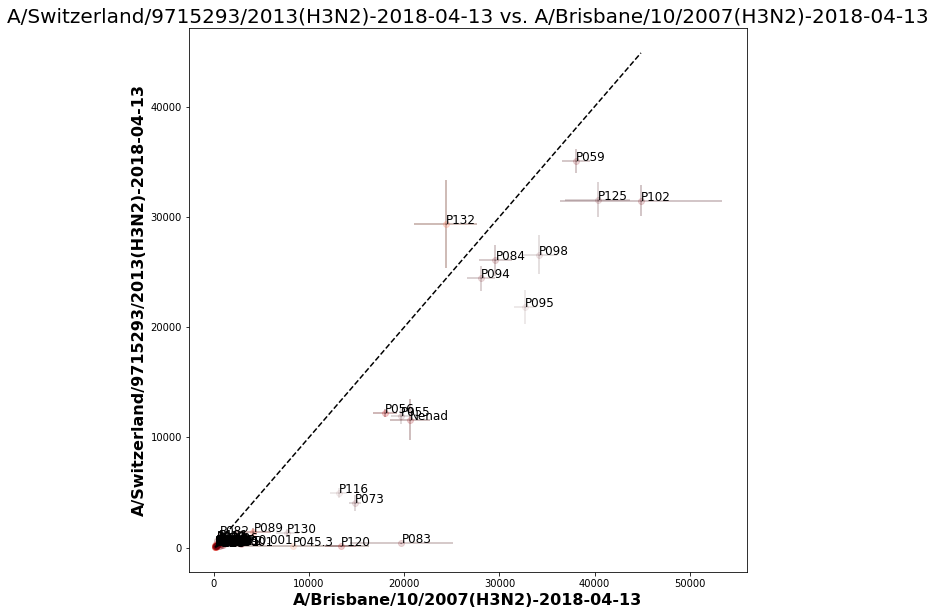

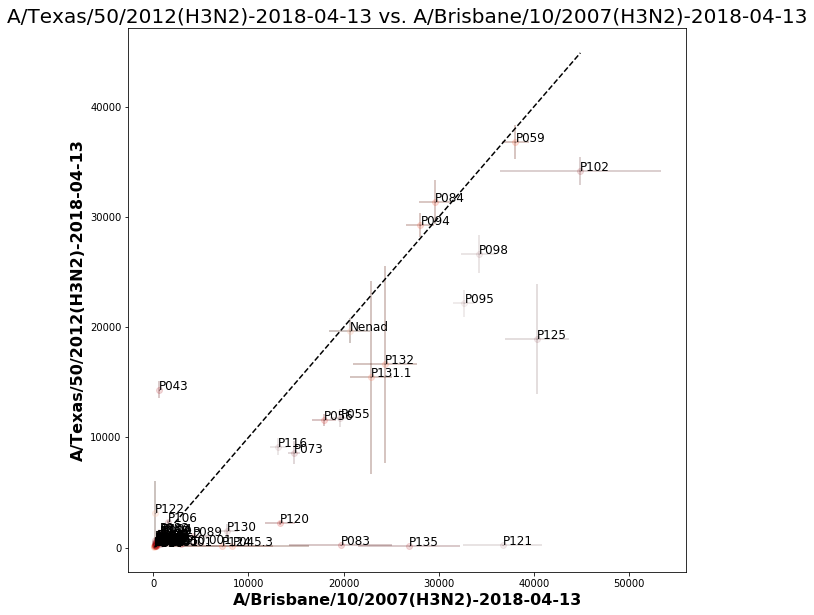

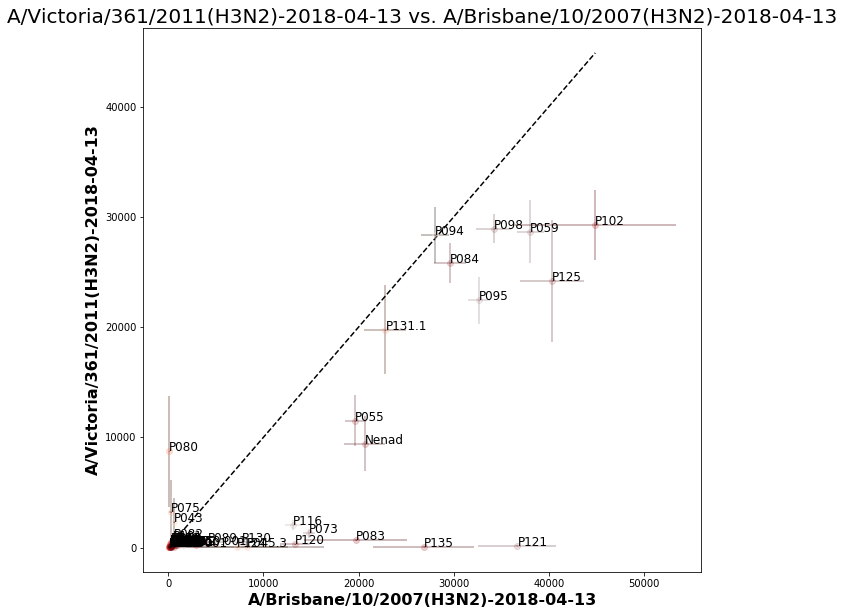

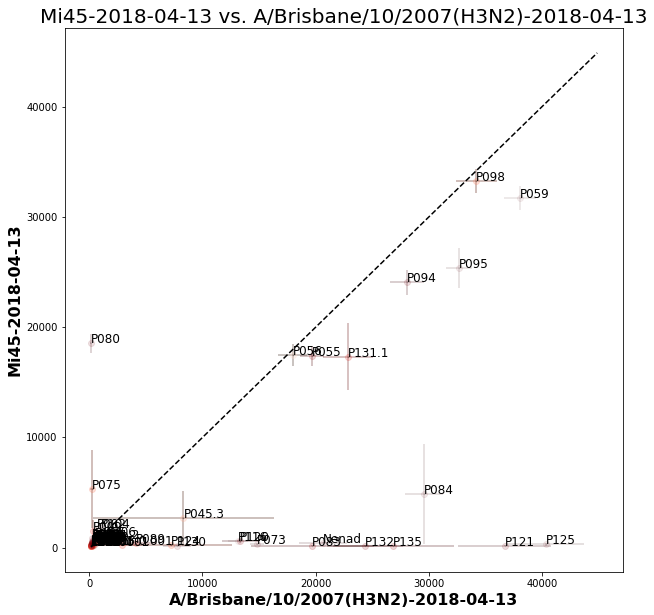

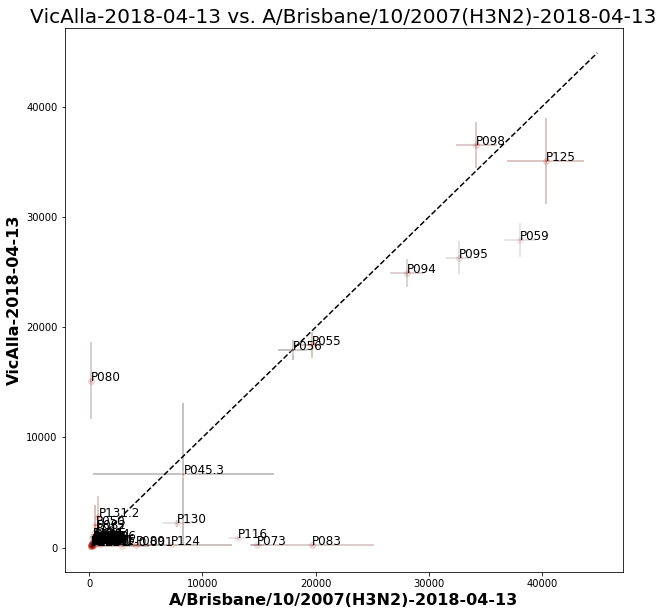

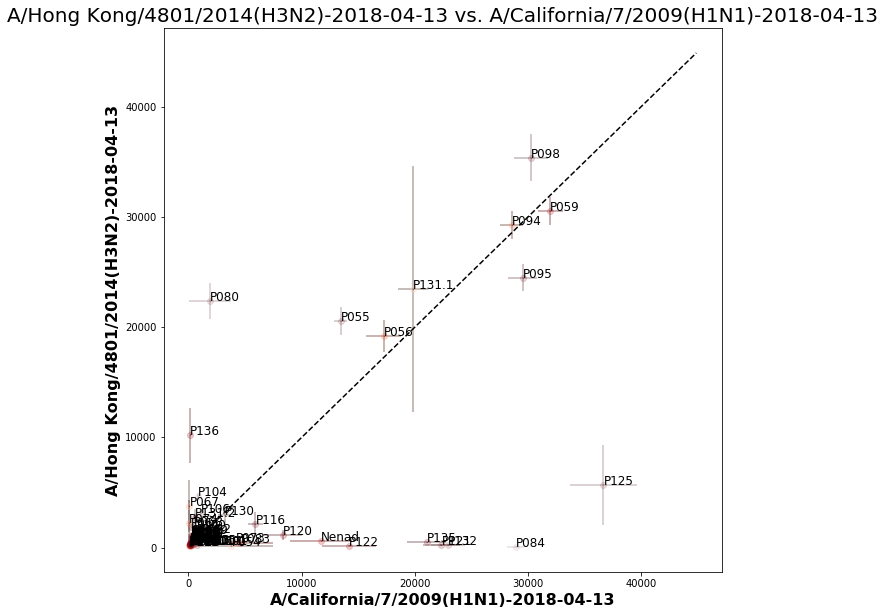

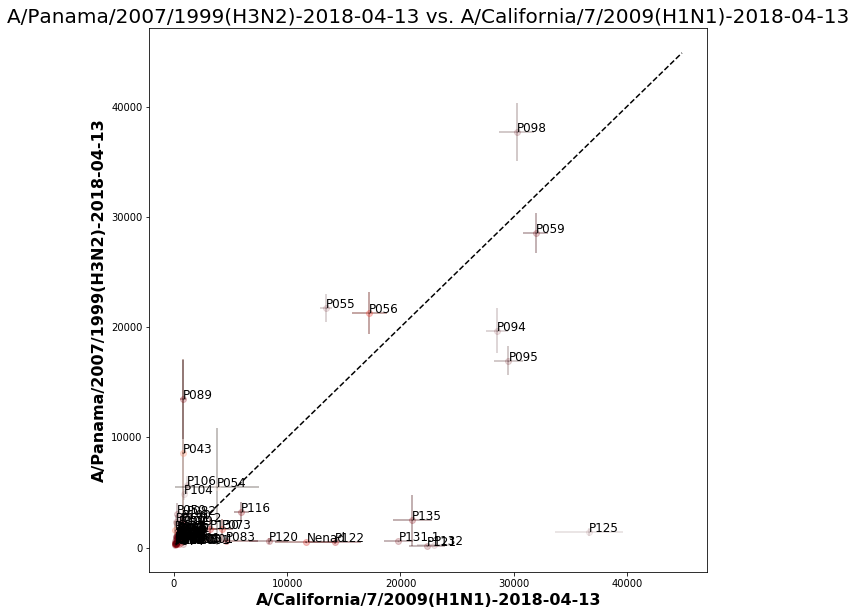

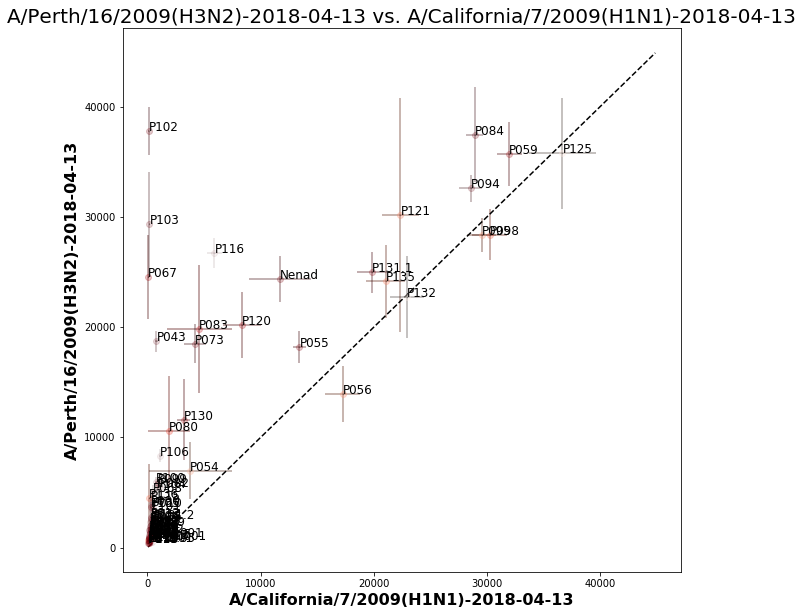

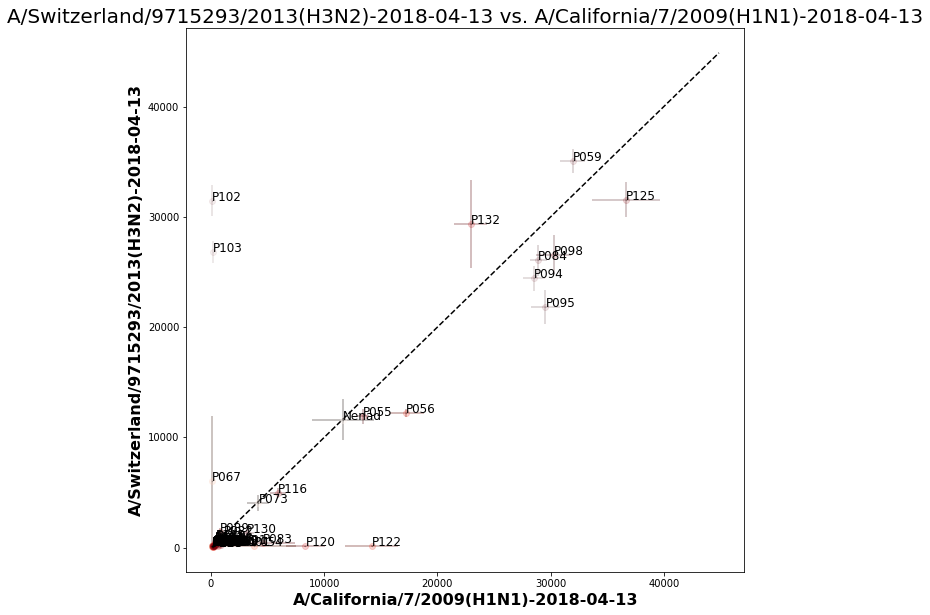

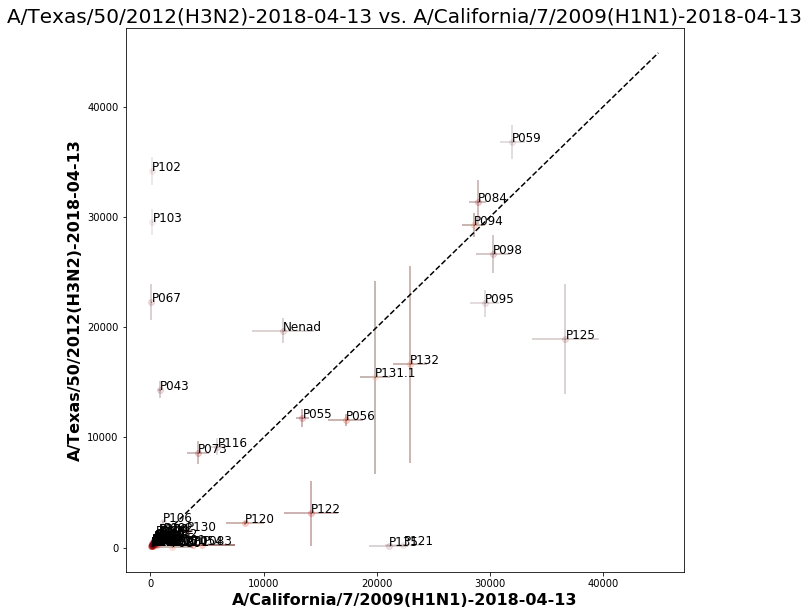

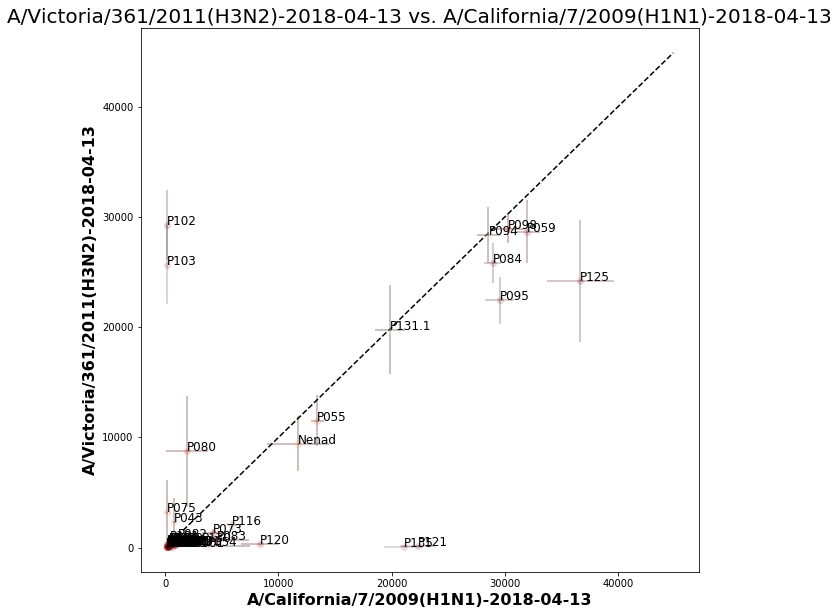

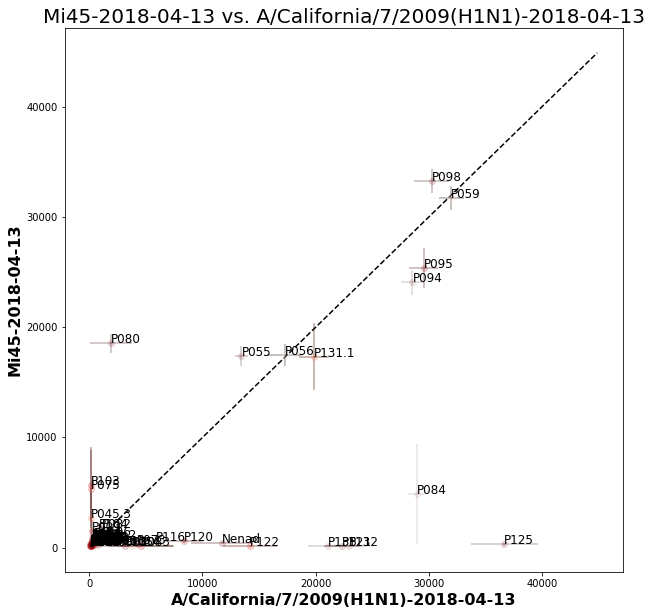

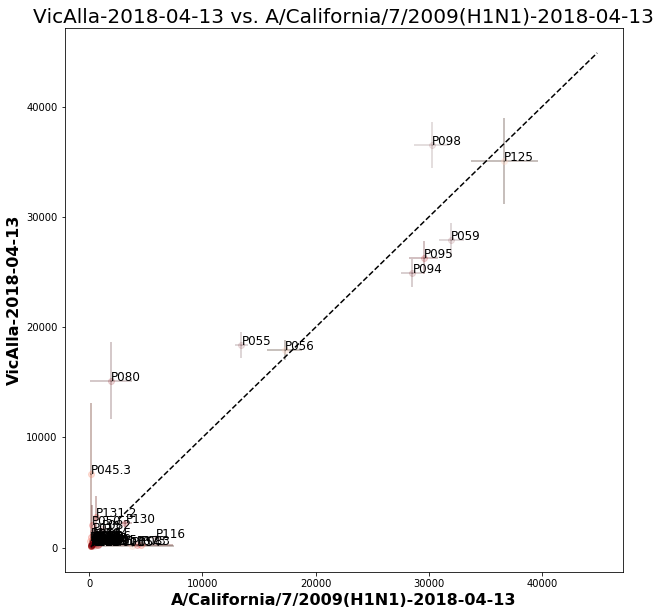

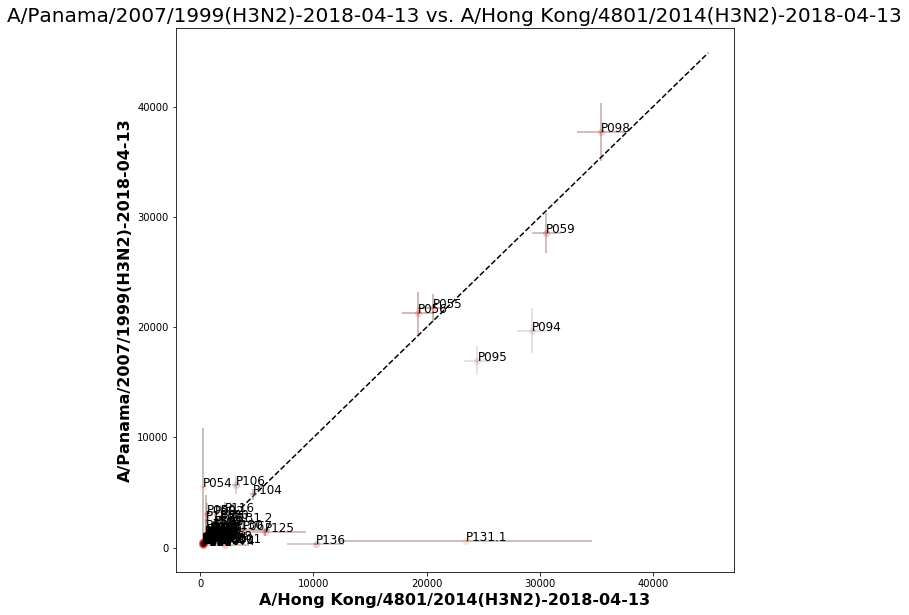

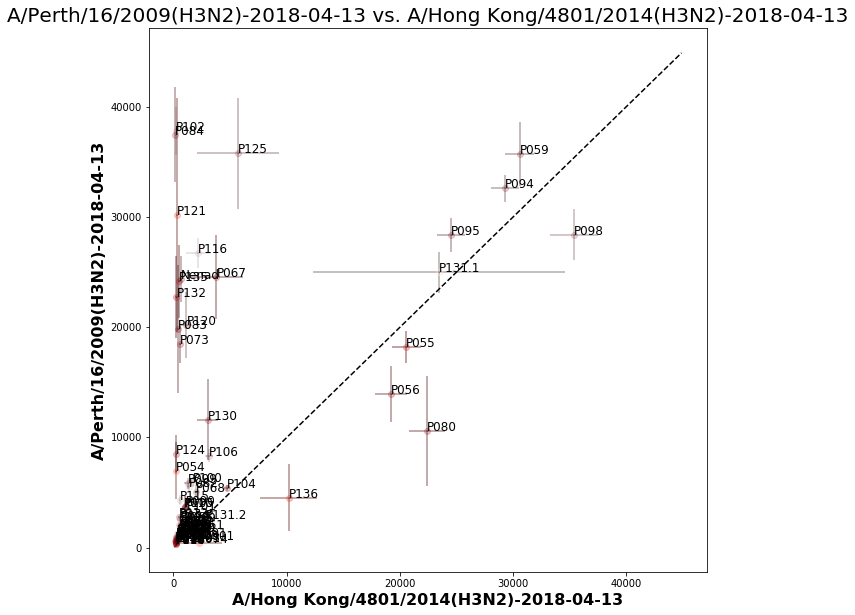

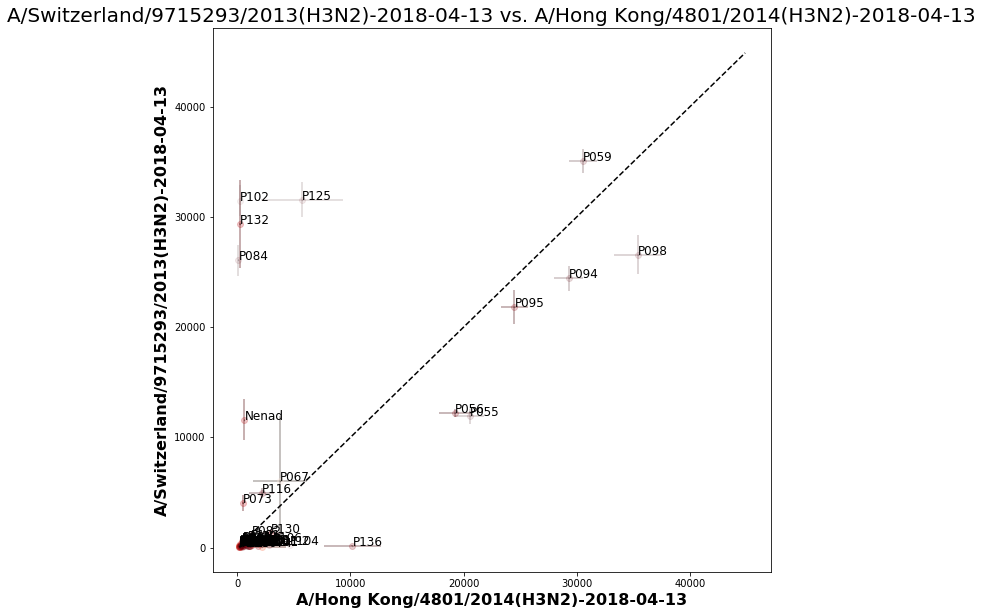

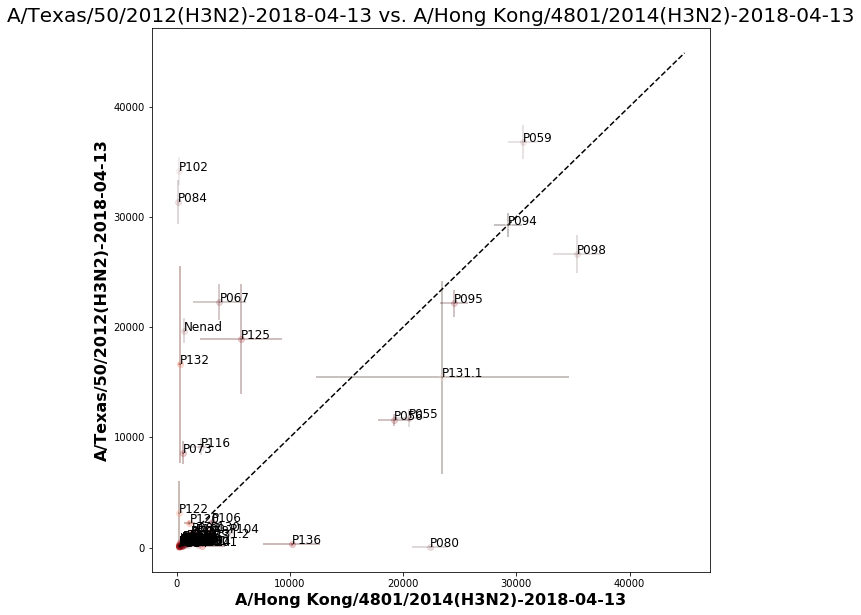

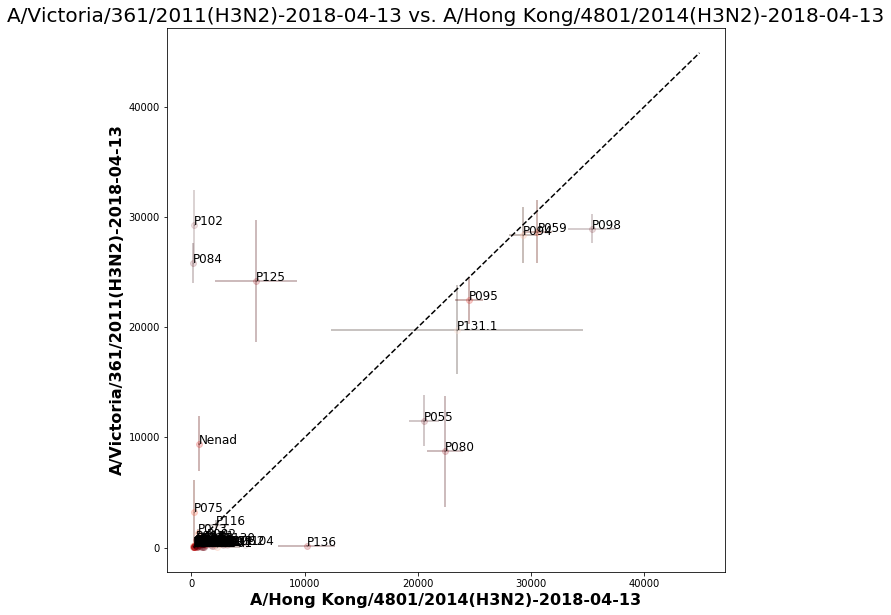

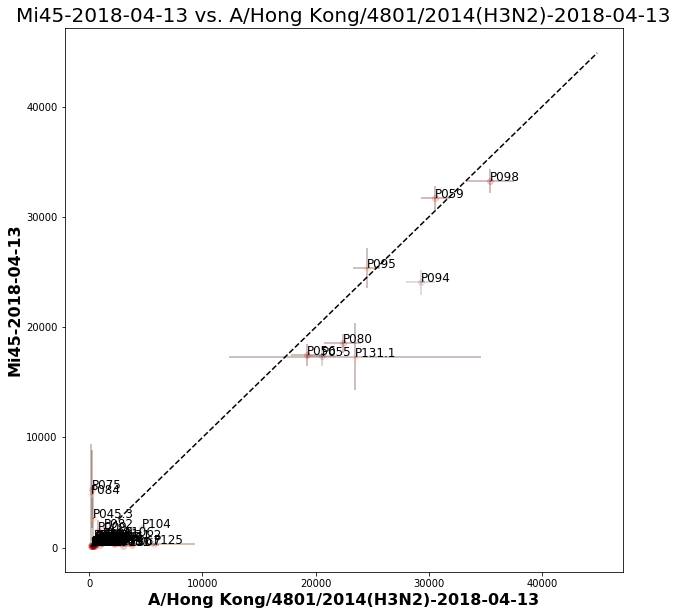

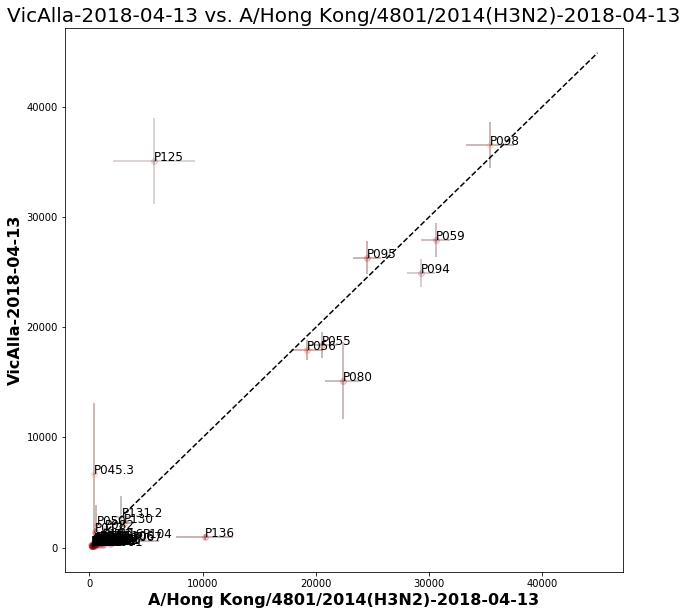

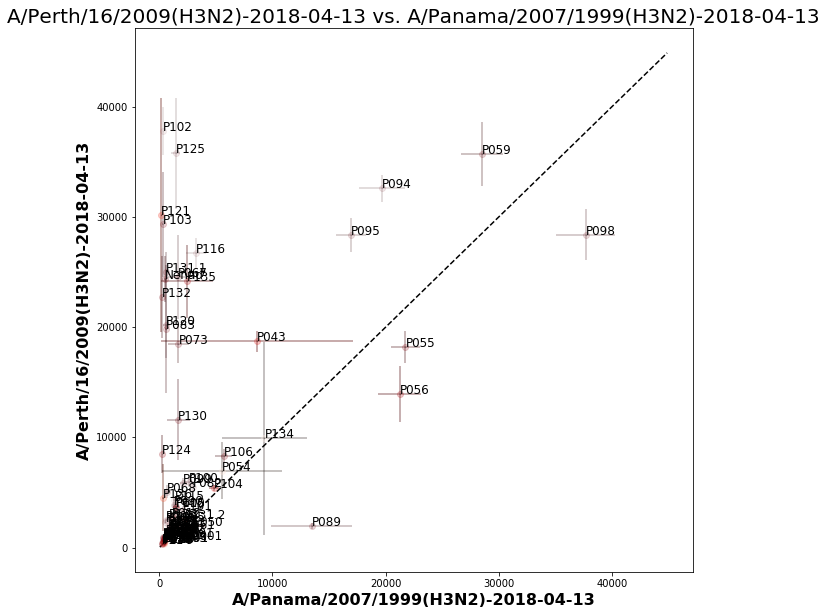

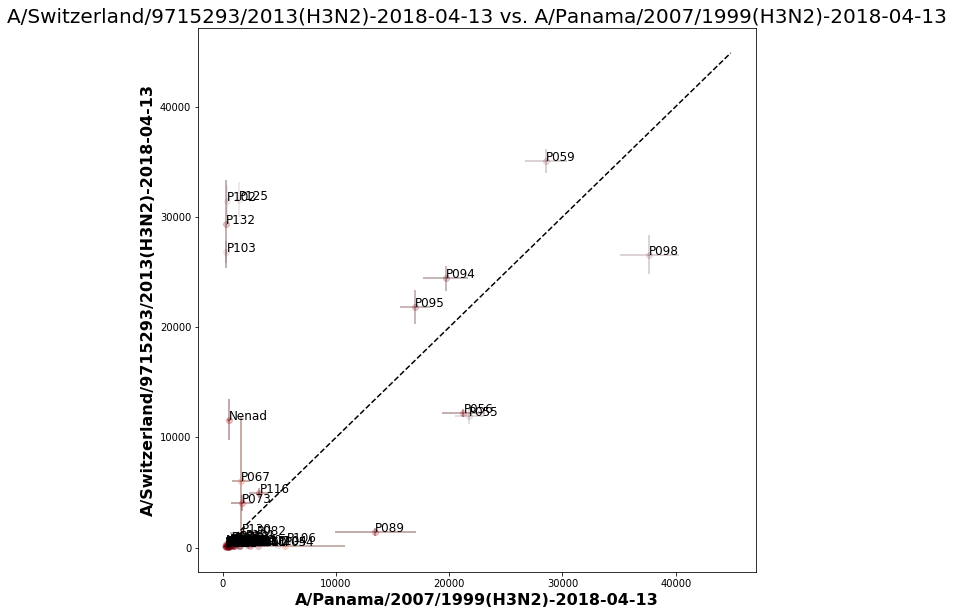

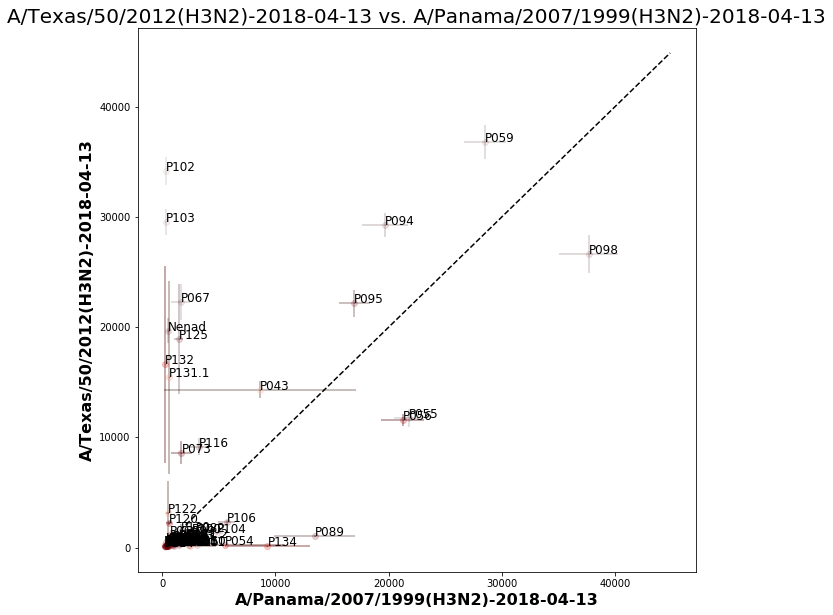

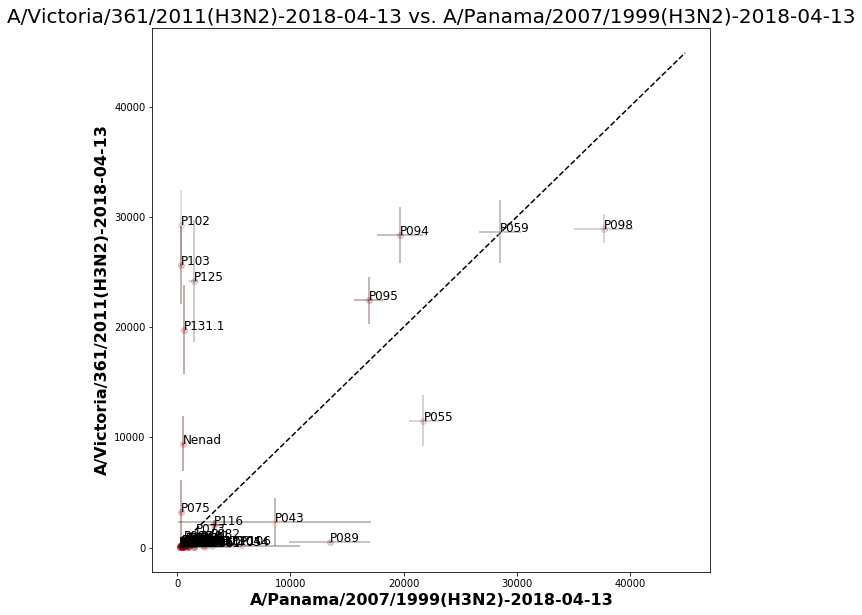

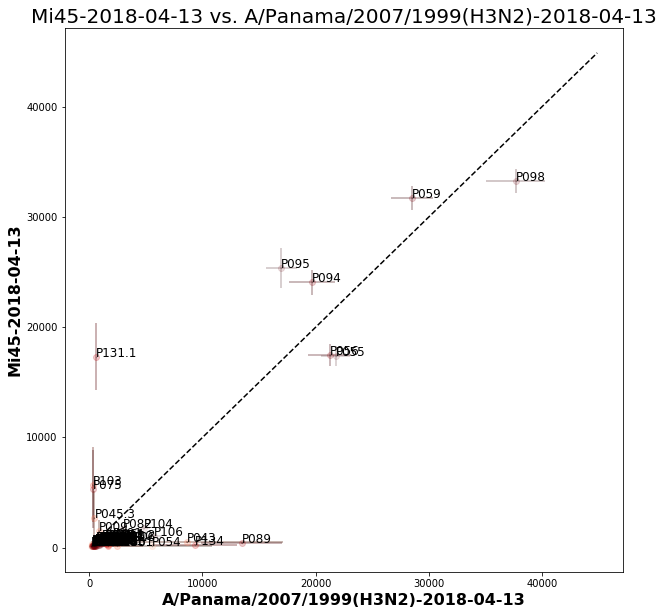

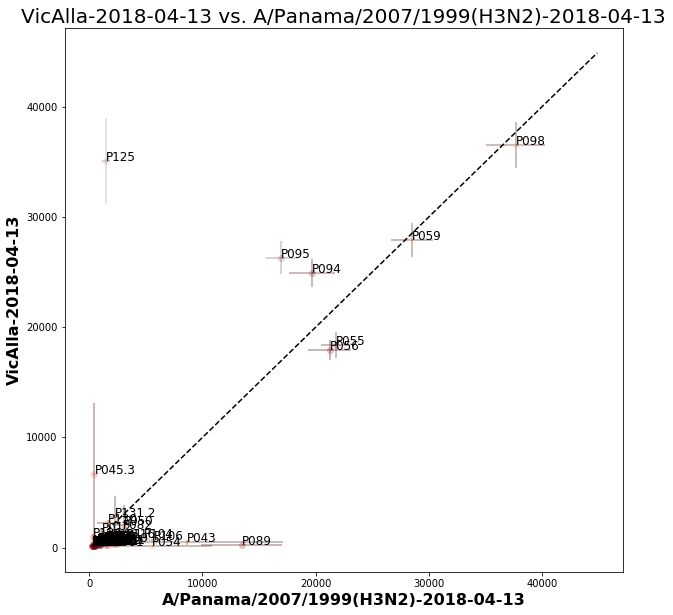

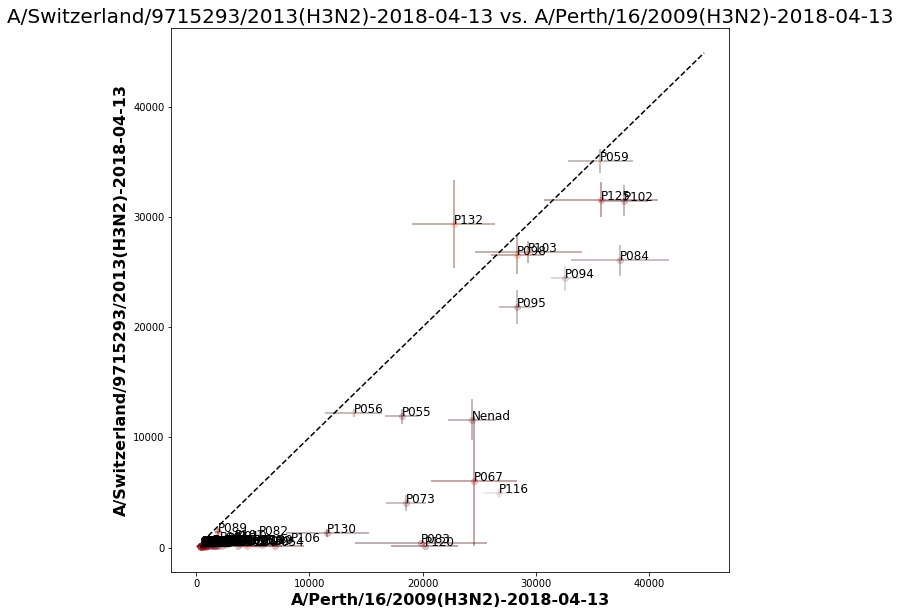

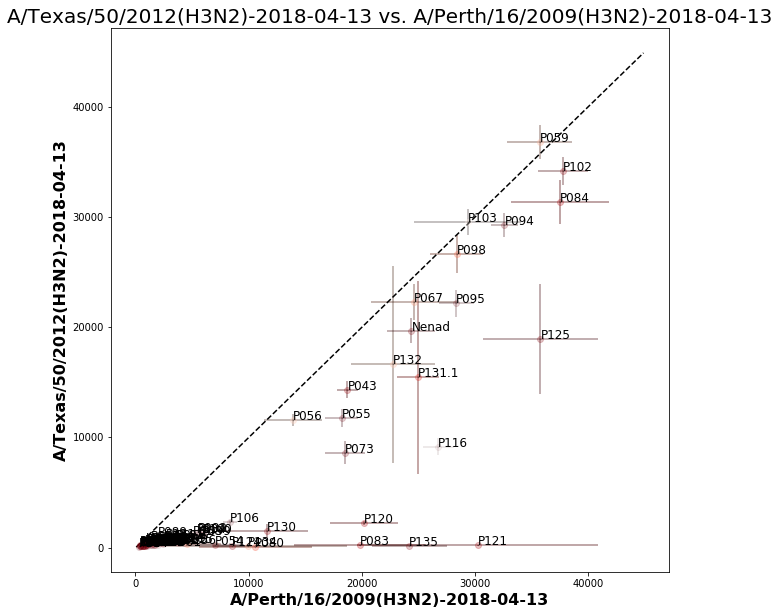

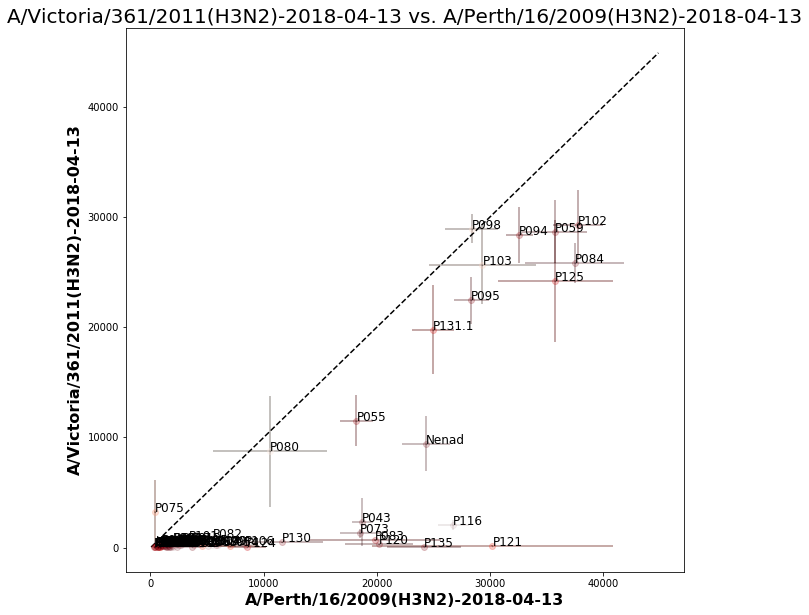

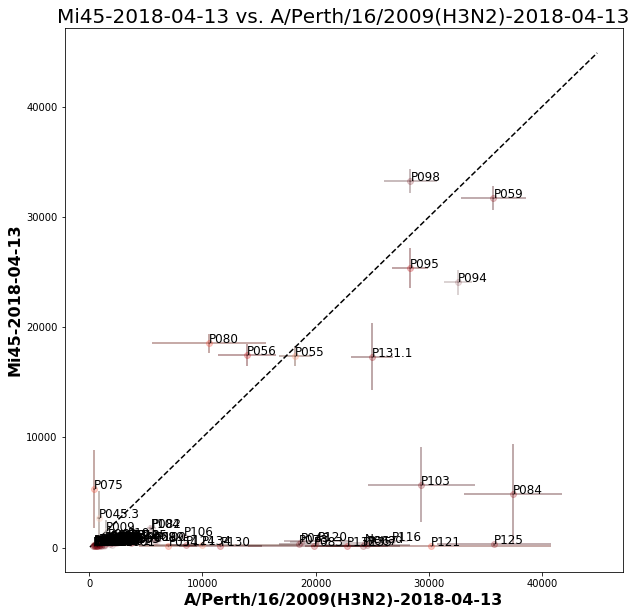

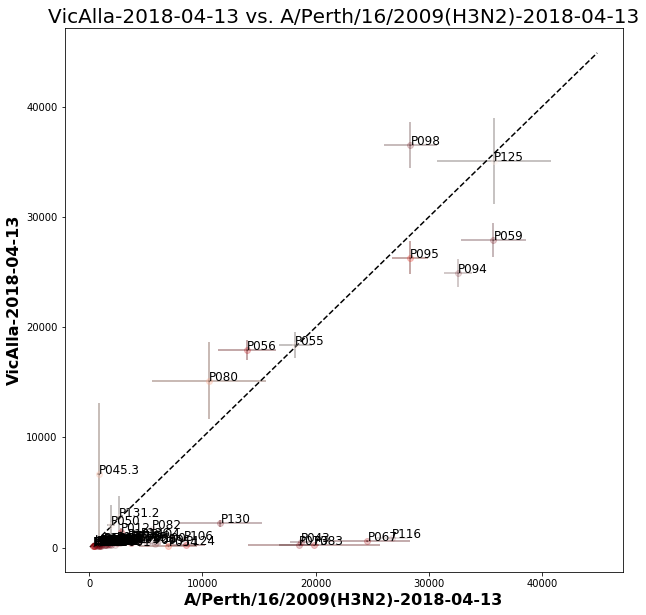

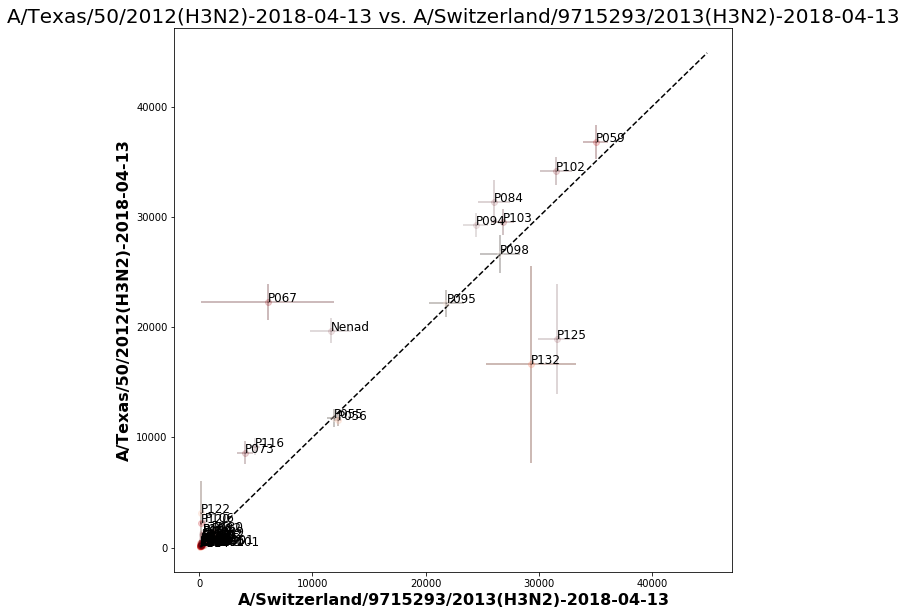

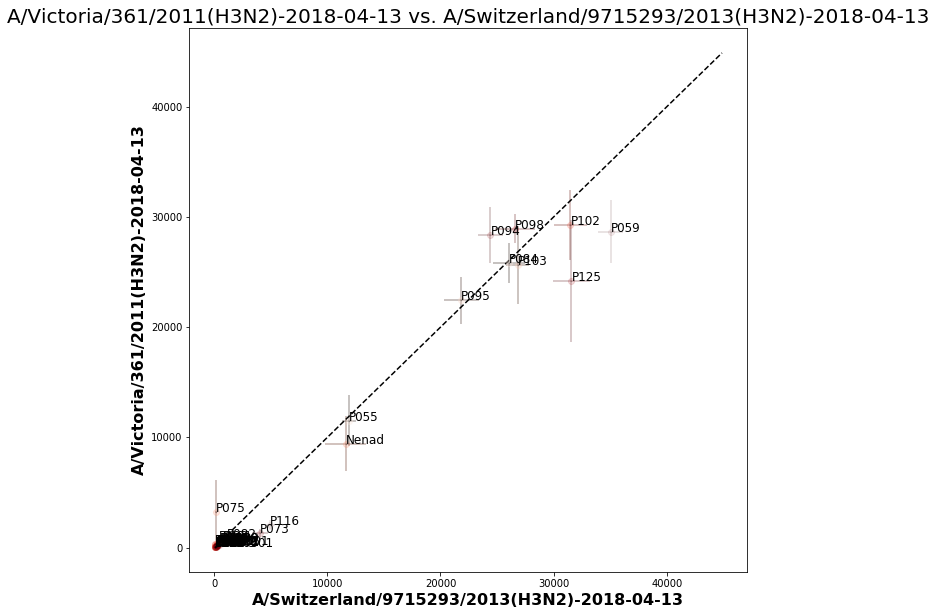

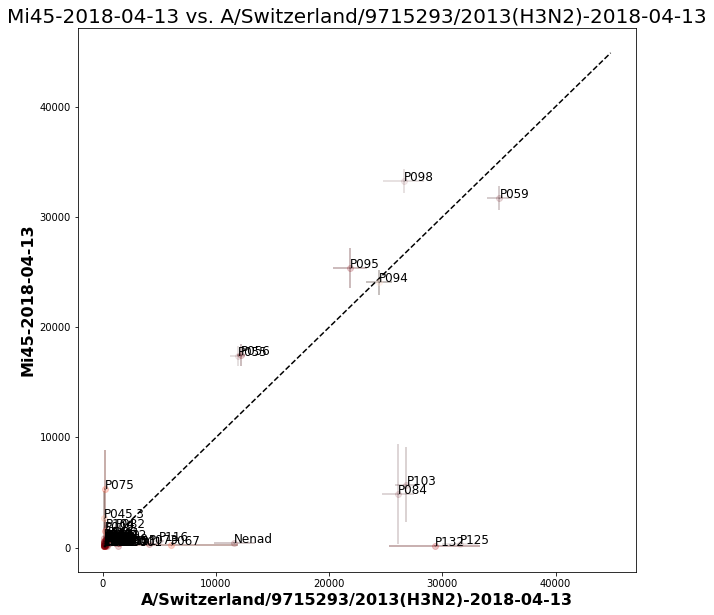

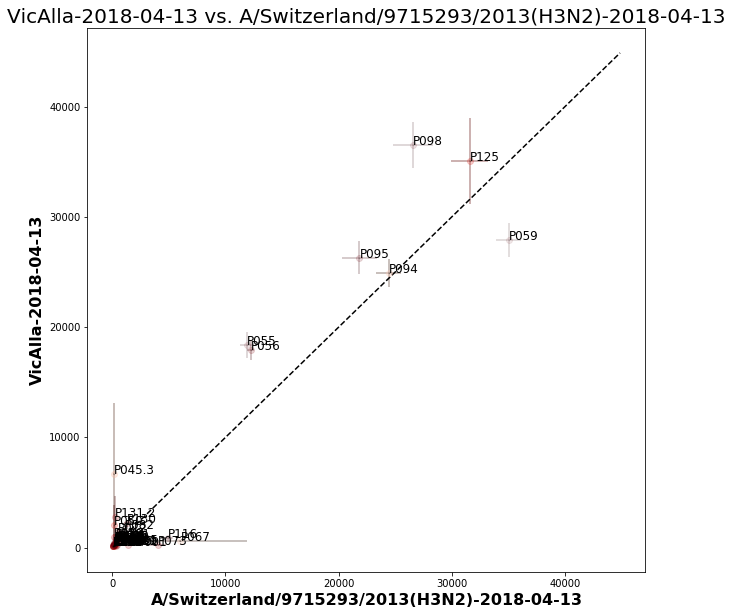

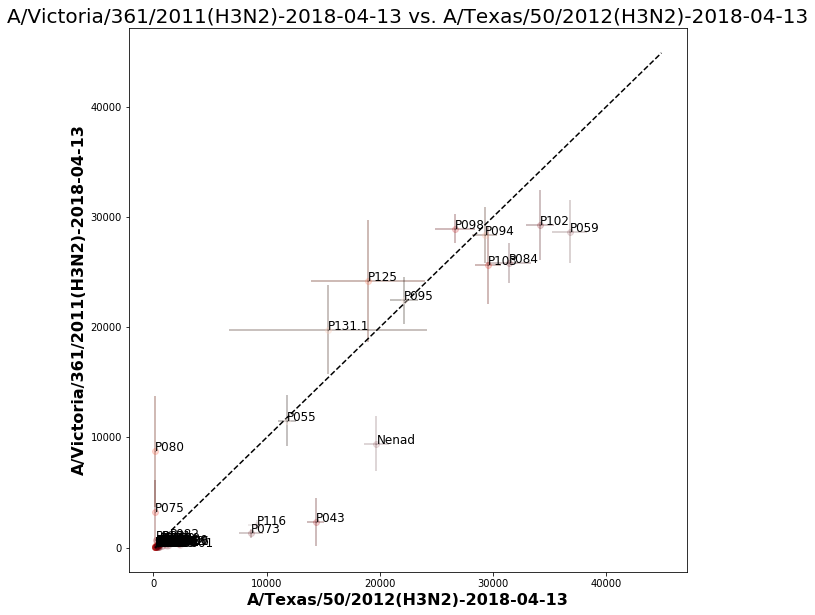

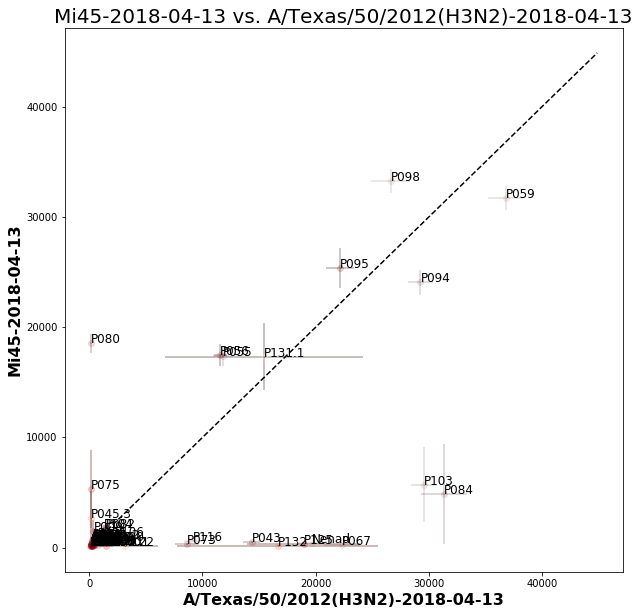

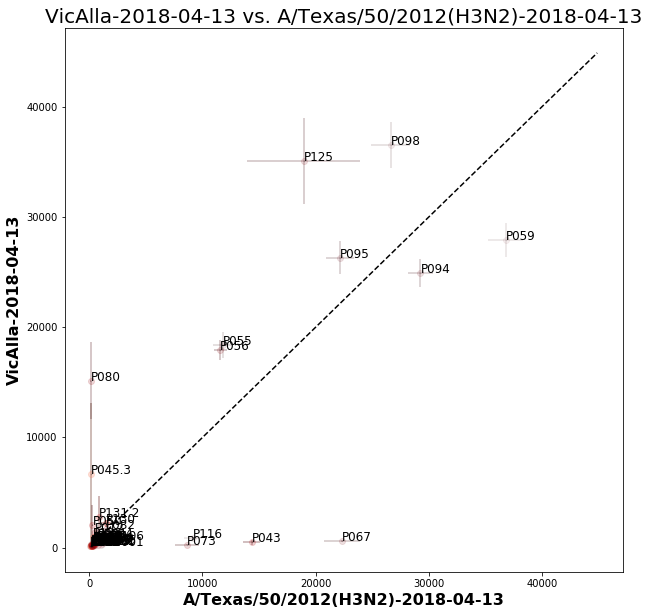

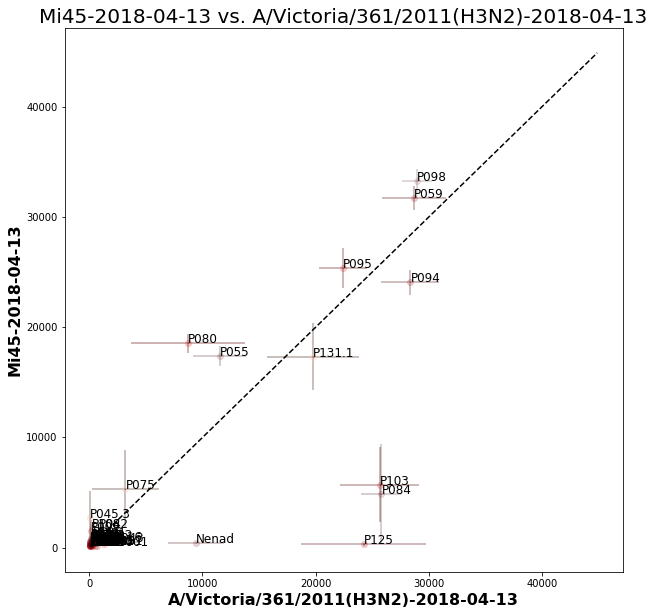

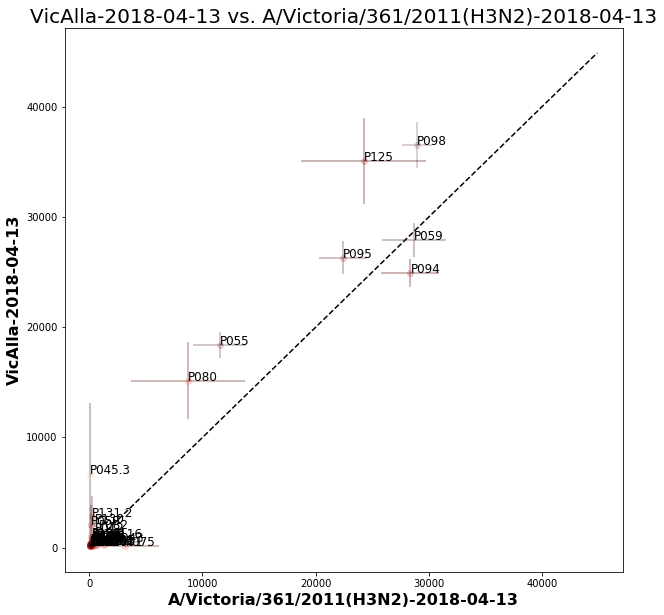

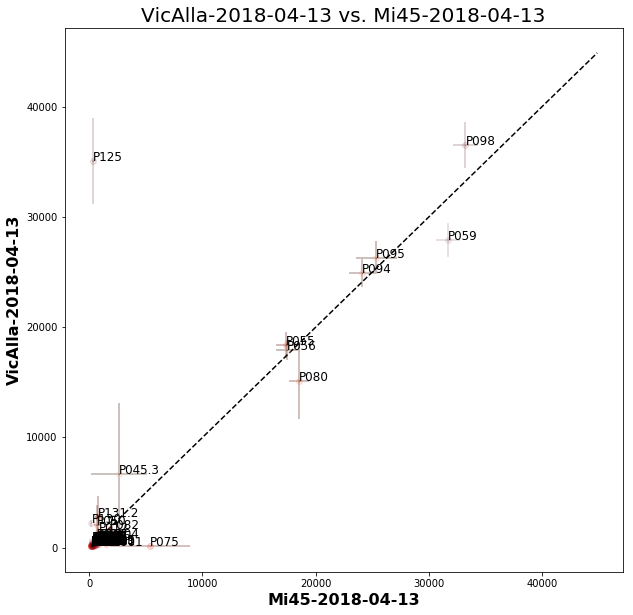

In [45]:
#fig, axes = plt.subplots(ncols=5,nrows=2, figsize = (25,10), sharey=True)

#ax_it = iter(axes.flatten())
peptide_c_signif.dropna(inplace=True)
cmap = cm.Reds
for name, d in peptide_c_signif.groupby("Analyte Batches"):
    x = y = np.linspace(peptide_c_signif.V1_I.min(),peptide_c_signif.V1_I.max())
    #ax = next(ax_it)
    fig, ax = plt.subplots(1,1,figsize=(10,10))

    ax.plot(x,y,linestyle="--",marker=" ", c="k", alpha=1)
    ax.set_title("{} vs. {}".format(name[1],name[0]), size = 20)
    ax.set_xlabel(name[0], size = 16, weight = 'bold')
    ax.set_ylabel(name[1], size = 16, weight = 'bold')
    #ax.set_xlim(0,x.max())
    #ax.set_ylim(0,y.max())

    
    #ax.set_xscale("log")
    #ax.set_yscale("log")



    #norm = Normalize(d.Significance.min(),d.Significance.max())
    d.sort_values("Significance",ascending=False, inplace=True)
    boundary = 0.15
    #d_selected = d[d["Significance"] < boundary]
    #d_n = d[d["Significance"] > boundary]
    
    #d_selected = d.loc[d["Ligand Batch"].isin(["P095","P059","P094","Nenad","P102"])]
    d_selected = d


    d_n = d
    #d_selected = d.loc[d["Peptide"].isin(["Pep_80","Pep_43","Pep_55","Pep_56","Pep_59","Pep_61","Pep_63","Pep_83","Pep_94","Pep_95","Pep_98","Pep_100","Pep_102","Pep_103","Pep_121" ,"Pep_125","Pep_131.2","Nenad","Pep_49","Pep_50"])]
    #d_selected = d.loc[d["Ligand Batch"].isin(["Nenad"])]
    #d_selected = d.loc[d["Peptide"].isin(["Pep_43","Pep_55","Pep_56","Pep_59","Pep_63","Pep_131.2"])]


    

    alphas = iter(np.linspace(0.3,0.05,len(d)))    

    for ii, dp in d_selected.iterrows():
        #if dp.Significance is not np.NaN:
            c = cmap(1-dp.Significance**(1/6))
            ax.errorbar(x=dp.V1_I,y=dp.V2_I,xerr=dp.V1_Err,yerr=dp.V2_Err, c = c, fmt="o",linestyle="",alpha=next(alphas), capthick=2)
            ax.annotate(dp["Ligand Batch"],(dp.V1_I+0.01,dp.V2_I+0.01), size=12)
    alphas = iter(np.linspace(0.3,0.05,len(d)))    

    for ii, dp in d_n.iterrows():
        c = cmap(dp.Significance)
        ax.errorbar(x=dp.V1_I,y=dp.V2_I,xerr=dp.V1_Err,yerr=dp.V2_Err, c = "k", fmt="o",linestyle="",alpha=next(alphas), ms = 0.5, capthick=1)
        
    #extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    uri_name1 = name[0].replace("/","-")
    uri_name2 = name[1].replace("/","-")
    #plt.savefig(uri_name1+uri_name2+"correlations.png", bbox_inches="tight")   
    plt.show()


#plt.savefig(directory+"all_correlations.png", bbox_inches="tight")    
plt.show()    

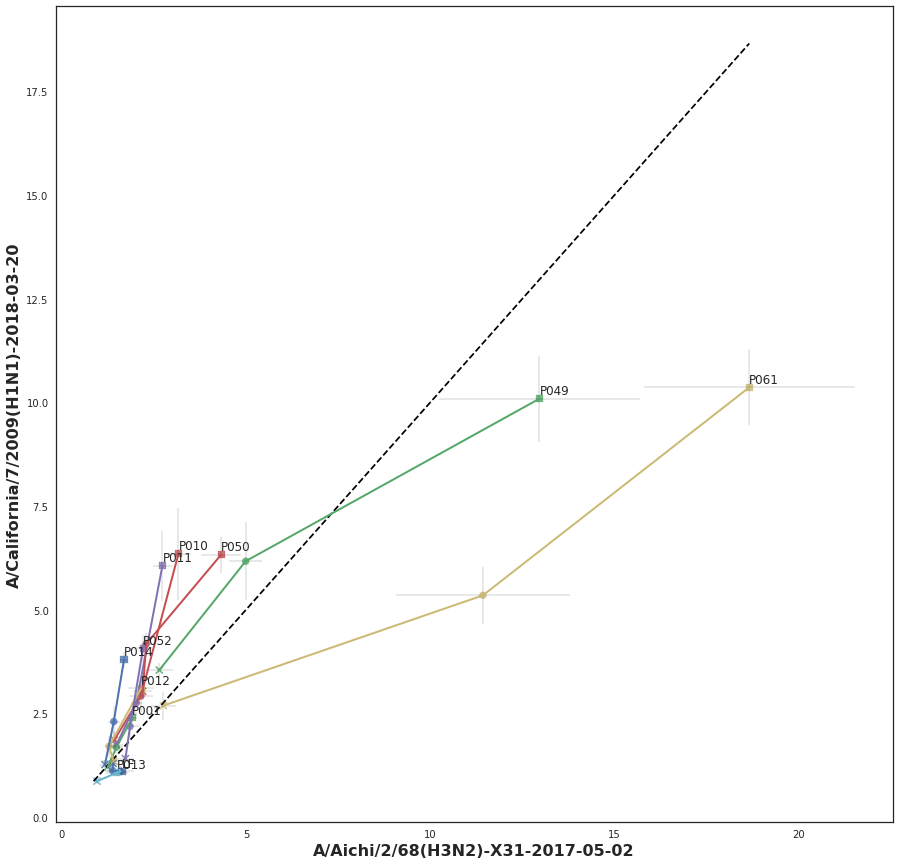

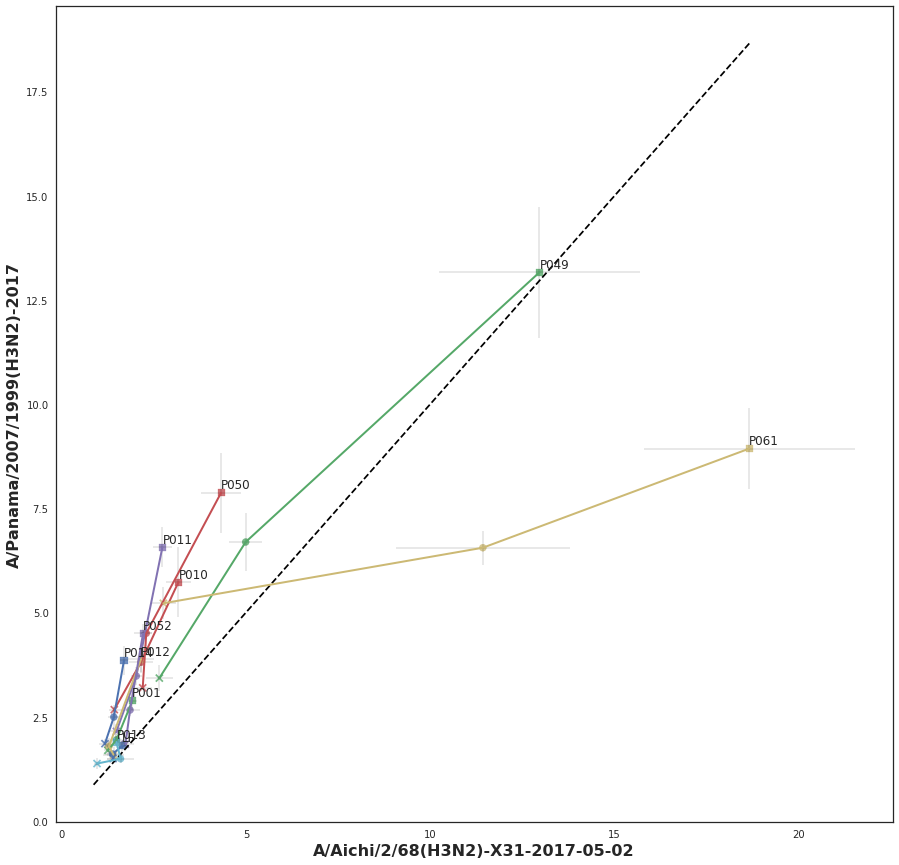

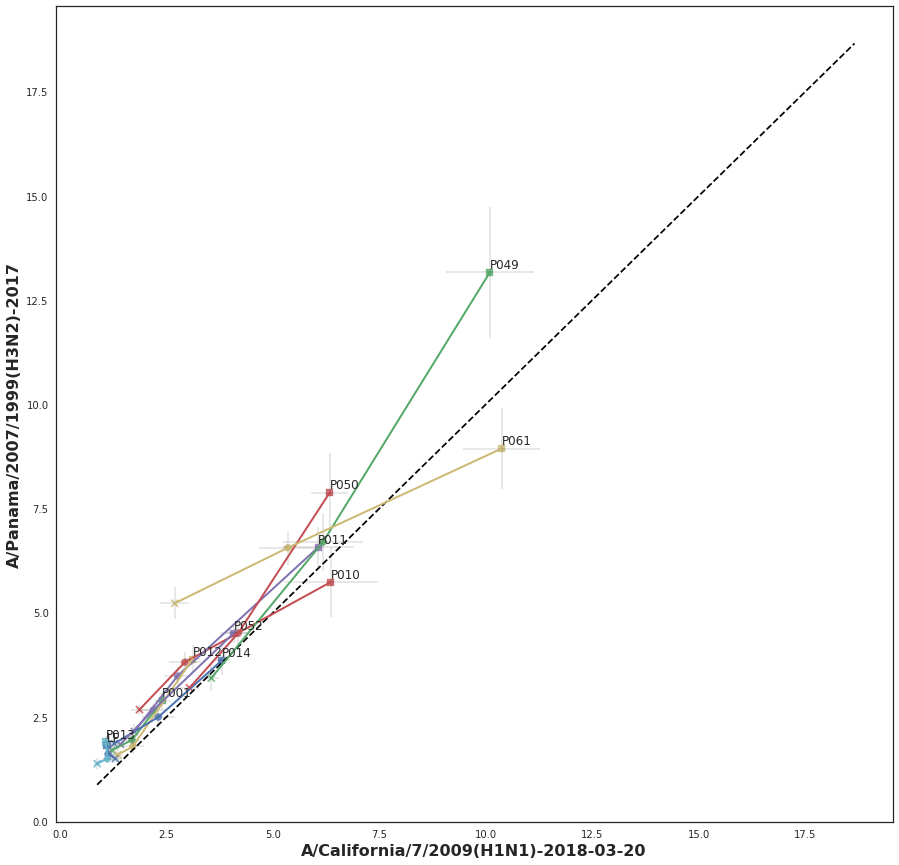

In [546]:
#fig, axes = plt.subplots(ncols=5,nrows=2, figsize = (25,10), sharey=True)
#ax_it = iter(axes.flatten())
peptide_c_signif.dropna(inplace=True)
cmap = cm.viridis
#mask = peptide_c_signif["Ligand"].isin(['P013','P001',"P012","LF"])
p_selected = peptide_c_signif#[~mask]
for name, d in p_selected.groupby("Analyte Batches"):
    markers = iter(["x","o","s"])

    x = y = np.linspace(p_selected.V1_I.min(),p_selected.V1_I.max())
    #ax = next(ax_it)
    fig, ax = plt.subplots(1,1,figsize=(15,15))

    ax.plot(x,y,linestyle="--",marker=" ", c="k", alpha=1)
    #ax.set_title("{} vs. {}".format(name[1],name[0]), size = 20)
    ax.set_xlabel(name[0], size = 16, weight = 'bold')
    ax.set_ylabel(name[1], size = 16, weight = 'bold')
    #ax.set_xlim(0,x.max())
    #ax.set_ylim(0,y.max())
    
    #ax.set_xscale("log")
    #ax.set_yscale("log")

    colors = []
    
    for name,dp in d.sort_values(by="Ligand").groupby("Ligand"):
        
        
    
        
        
        dp_sort1 = dp.sort_values(by="Ligand Batch Concentration")
        #display(dp_sort)
        #c = cmap(dp.Significance)
        #ax.errorbar(x=dp.V1_I,y=dp.V2_I,xerr=dp.V1_Err,yerr=dp.V2_Err, c = "k", fmt="o",linestyle="--", ms = 0.5, capthick=1)
        #ax.annotate(dp["Ligand Batch"],(dp.V1_I+0.01,dp.V2_I+0.01), size=12)
        lines = ax.plot(dp_sort1.V1_I,dp_sort1.V2_I, label=name,alpha=1.0,linewidth=2.0,linestyle="-")
        colors.append(lines[0].get_color())
       
        

        
    for concentration ,dp in d.groupby("Ligand Batch Concentration"):
        dp_sort = dp.sort_values(by="Ligand")

        ax.errorbar(x=dp.V1_I,y = dp.V2_I,xerr=dp.V1_Err,yerr=dp.V2_Err, marker="", c="k", linestyle="",alpha=0.1)
        
    
        ax.scatter(x=dp_sort.V1_I,y = dp_sort.V2_I,marker=next(markers), c=colors, alpha=0.8,s=50)
        
        if concentration == 1.0:
            for i,n in enumerate(dp):
                ax.annotate(dp["Ligand"].iloc[i],(dp.V1_I.iloc[i]+0.0,dp.V2_I.iloc[i]+0.1), size=12)
       


    
                             
    #leg = ax.legend() 
    #for line in leg.get_lines():
    #    line.set_linewidth(6.0)

    

    #alphas = iter(np.linspace(0.3,0.05,len(d)))
    

    #for ii, dp in d_selected.iterrows():
        #if dp.Significance is not np.NaN:
    #        c = cmap(dp.Significance)
    #        ax.errorbar(x=dp.V1_I,y=dp.V2_I,xerr=dp.V1_Err,yerr=dp.V2_Err, c = c, fmt="o",linestyle="",alpha=0.8, capthick=2)
    #        ax.annotate(dp["Ligand Batch"],(dp.V1_I+0.01,dp.V2_I+0.01), size=12)
    
    #for ii, dp in d_n.iterrows():
    #    c = cmap(dp.Significance)
    #    ax.errorbar(x=dp.V1_I,y=dp.V2_I,xerr=dp.V1_Err,yerr=dp.V2_Err, c = "k", fmt="o",linestyle="",alpha=next(alphas), ms = 0.5, capthick=1)
        
    #extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    #uri_name1 = name[0].replace("/","-")
    #uri_name2 = name[1].replace("/","-")
    #plt.savefig(uri_name1+uri_name2+"correlations.png", bbox_inches="tight")
    #plt.savefig("all_correlations.svg", bbox_inches="tight")    

    plt.show()


#plt.show()    

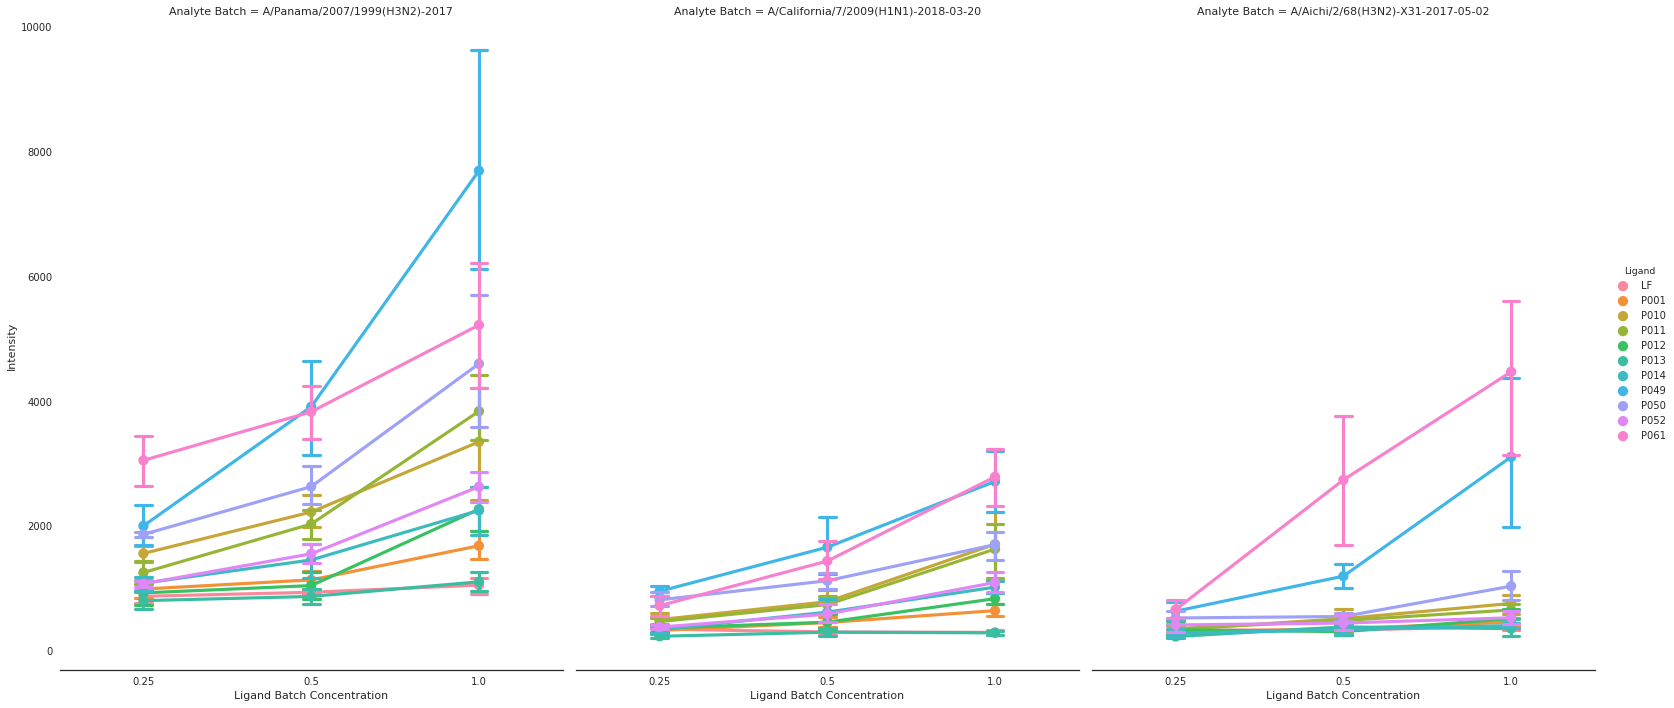

In [547]:
import seaborn as sns

sns.set(style="white")
g = sns.factorplot(x="Ligand Batch Concentration", y="Intensity", hue="Ligand", col="Analyte Batch", data=data.spots_pd,
                   capsize=.1,  size=10, aspect=.75)
g.despine(left=True)
plt.show()